<a href="https://colab.research.google.com/github/bori00/BrainTumorClassification/blob/bori_dev/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification

## Introduction

Just a few things that I found and may help you:

Summary:

**Glioma tumors**

*   cause: glial cells grow out of control due to DNA changes
*   type: **malignant** (cancerous)
*   location: depends on the subtype.
*   treatment: possible, but difficult (hard to reach with surgery, may grow into other areas of the brain). Requires a combination of surgery, radiation therapy and chemotherapy
*   frequency: ~25% of all detected brain tumors are gliomas
*   diagnosis: first, an MRI or CT scan is made. If an abnormal mass is found, a biopsy is made. 
*   treatment: the primary treatment is surgery, which is usually followed by chemotherapy and radiation therapy.
*  [source](https://my.clevelandclinic.org/health/diseases/21969-glioma#:~:text=A%20glioma%20is%20a%20tumor%20that%20forms%20when%20glial%20cells,can%20be%20very%20slow%20growing.)

**Meningioma tumors**

*  cause: 40-80% of all meningiomas have an abnormality in chromosome 22, which is partially responsible for surpressing the growth of tumors. Also, a correlation between hormones and meningiomas were found.
*   type: 
  *   grade I: **bening**, and grows slowly
  *   grade II: atypical, grows more quickly
  *   grade III: **malignant**, grows and spreads quickly
*  location: generally found on the outer surface the brain. The source is the menigers, the layers of tissue that cover the brain and spinal cord
*  frequency: represent ~33% of all brain tumors
*  diagnosis: the first step involves an MRI or a CT scan, and it is sometimes enough for a full diagnosis. Otherwise, a biopsy may be needed.
*  treatment: usually by radiosurgery and surgery. Chemotherapy is only applied for malignant tumors.
*  [source](https://my.clevelandclinic.org/health/diseases/17858-meningioma)


**Pituitary tumors**


*   cause: accidental changes in the DNA
*   type: mostly **bening**, and they do not spread in other parts of the body. 
*   location: in the pituitary gland (found behind the nose and the sphenoid sinus). May cause a hormone deficiency.
*   diagnosis: an MRI or CT scan is usually enough, together with a medical background check
*   frequency: doctors found that almost 25% of the populations had a pituitary adenoma, but most of them are never detected. Approximately 12.5% of all brain tumors are pituitary tumors.
*   treatment: usually, immediate treatment is not required. The tumor may be removed, the growth may be controlled or the hormone levels may be managed with medications. 
*   [source1](https://my.clevelandclinic.org/health/diseases/15328-pituitary-adenomas-), [source2](https://www.mayoclinic.org/diseases-conditions/pituitary-tumors/symptoms-causes/syc-20350548#:~:text=A%20pituitary%20tumor%20is%20a,develop%20in%20your%20pituitary%20gland) 

## Setup

In [1]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization

from sklearn.metrics import confusion_matrix, classification_report, precision_score, balanced_accuracy_score

import urllib
from urllib import request

import time

from numpy.random import seed

from yellowbrick.classifier import ClassPredictionError

In [2]:
pip install -U matplotlib

In [3]:
# Reproducability
SEED = 31415
def set_seed(seed_value=SEED):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    seed(seed_value)
set_seed()

## Import Dataset

In [4]:
# mount google drive on the virtual machine created by colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# unzip the files containing the training and testing images
# important: this step assumes that you have the two zip files in 'BrainTumorClassification/Training.zip' and 'BrainTumorClassification/Testing.zip' in your Google Drive
!unzip gdrive/My\ Drive/BrainTumorClassification/Training.zip
!unzip gdrive/My\ Drive/BrainTumorClassification/Testing.zip

## Create Dataframes

Not all images ae of the same size, but 5012x512 is close to their original size.

In [6]:
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 32

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Training',
  shuffle=True,
  validation_split=0.2,
  subset="training",
  color_mode="grayscale",
  seed=SEED,
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  'Training',
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  color_mode="grayscale",
  seed=SEED,
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'Testing',
  shuffle=True,
  seed=SEED,
  color_mode="grayscale",
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [8]:
for x, y in train_ds.take(1):
  print("Shape of one batch in the   training dataset: ", x.shape, " with labels:", y)

for x, y in valid_ds.take(1):
  print("Shape of one batch in the validation dataset: ", x.shape, " with labels:", y)

for x, y in test_ds.take(1):
  print("Shape of one batch in the    testing dataset: ", x.shape, " with labels:", y)

Shape of one batch in the   training dataset:  (32, 512, 512, 1)  with labels: tf.Tensor([3 1 1 2 1 0 1 1 3 0 1 2 1 3 3 3 0 2 3 3 3 1 2 2 3 1 3 0 1 3 3 0], shape=(32,), dtype=int32)
Shape of one batch in the validation dataset:  (32, 512, 512, 1)  with labels: tf.Tensor([3 1 0 1 3 3 1 0 2 1 2 0 2 1 0 1 0 3 3 0 3 2 1 0 1 1 0 2 3 3 0 3], shape=(32,), dtype=int32)
Shape of one batch in the    testing dataset:  (32, 512, 512, 1)  with labels: tf.Tensor([3 3 1 0 2 0 2 2 3 1 2 1 2 0 2 1 2 1 2 0 2 0 1 0 1 1 2 3 1 1 2 3], shape=(32,), dtype=int32)


In [9]:
class_names = train_ds.class_names
print("Class Names: ", class_names)

Class Names:  ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


### Distributions

In [10]:
def get_distribution(ds):
  vals = np.unique(np.fromiter(ds.unbatch().map(lambda x, y: y), float), return_counts=True)
  dist = [0, 0, 0, 0]

  for val, count in zip(*vals):
    dist[int(val)] = count
  
  return dist

In [11]:
training_dist = get_distribution(train_ds)
valid_dist = get_distribution(valid_ds)
testing_dist = get_distribution(test_ds)

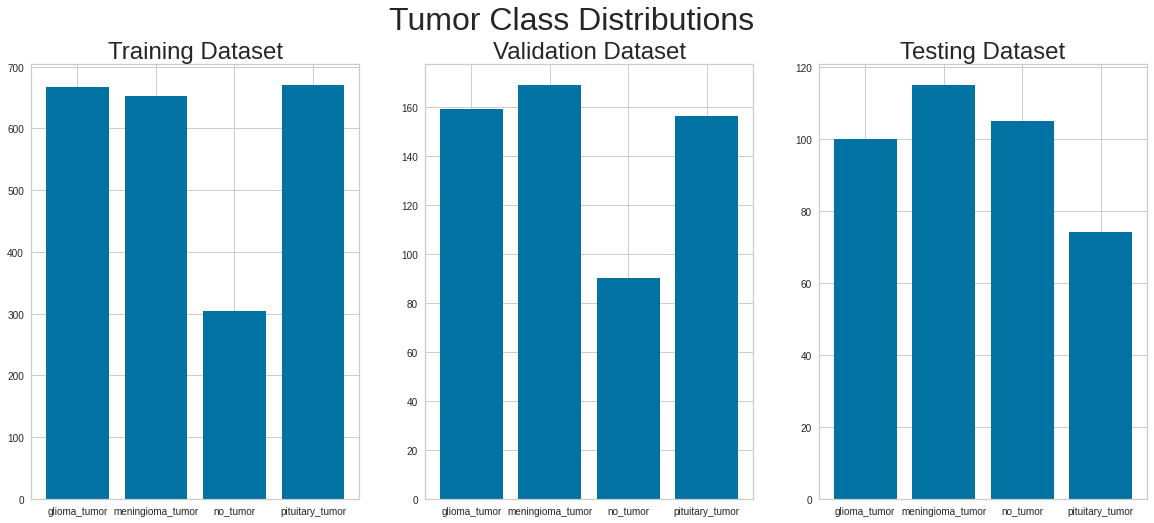

In [12]:
plt.figure(figsize=(20, 8))
plt.suptitle("Tumor Class Distributions", fontsize = 32)

plt.subplot(1, 3, 1)
plt.title("Training Dataset", fontsize = 24)
plt.bar(range(len(training_dist)), training_dist, tick_label=class_names)

plt.subplot(1, 3, 2)
plt.title("Validation Dataset", fontsize = 24)
plt.bar(range(len(valid_dist)), valid_dist, tick_label=class_names)

plt.subplot(1, 3, 3)
plt.title("Testing Dataset", fontsize = 24)
plt.bar(range(len(testing_dist)), testing_dist, tick_label=class_names)

plt.show()

The training and validation dataset are well-balanced, as they were programatically generated, but the test dataset, downloaded from kaggle, has a significantly different class distribution from that of the other datasets: the no_tumor class is overrepresented in the test dataset compared to the other two.

## Visualize data

In [13]:
def categorize_images(batch):
  cardinalities = [0, 0, 0, 0]
  cat_images = [[], [], [], []]

  for images, labels in batch:
    for i in range(images.shape[0]):
        category = int(labels[i])
        cardinalities[category] = cardinalities[category] + 1
        cat_images[category].append(images[i].numpy().astype("uint8"))
  
  return cat_images, cardinalities

In [14]:
def visualize_batch_per_categories(batch):
  cat_images, cardinalities = categorize_images(batch)

  no_columns = max(cardinalities)

  # create 4x1 subplots
  fig, axs = plt.subplots(nrows=4, ncols=1, constrained_layout=True)
  fig.set_figheight(20)
  fig.set_figwidth(4 * no_columns)
  fig.suptitle('The content of one Batch', fontsize = 64)

  # clear subplots
  for ax in axs:
      ax.remove()

  # add subfigure per subplot
  gridspec = axs[0].get_subplotspec().get_gridspec()
  subfigs = [fig.add_subfigure(gs) for gs in gridspec]

  for row, subfig in enumerate(subfigs):
      subfig.suptitle(class_names[row], fontsize = 32)

      # create 1x3 subplots per subfig
      axs = subfig.subplots(nrows=1, ncols=no_columns)
      for col, ax in enumerate(axs):
          if (cardinalities[row] > col):
            ax.plot()
            ax.grid(False)
            ax.imshow(cat_images[row][col-1], cmap="gray")

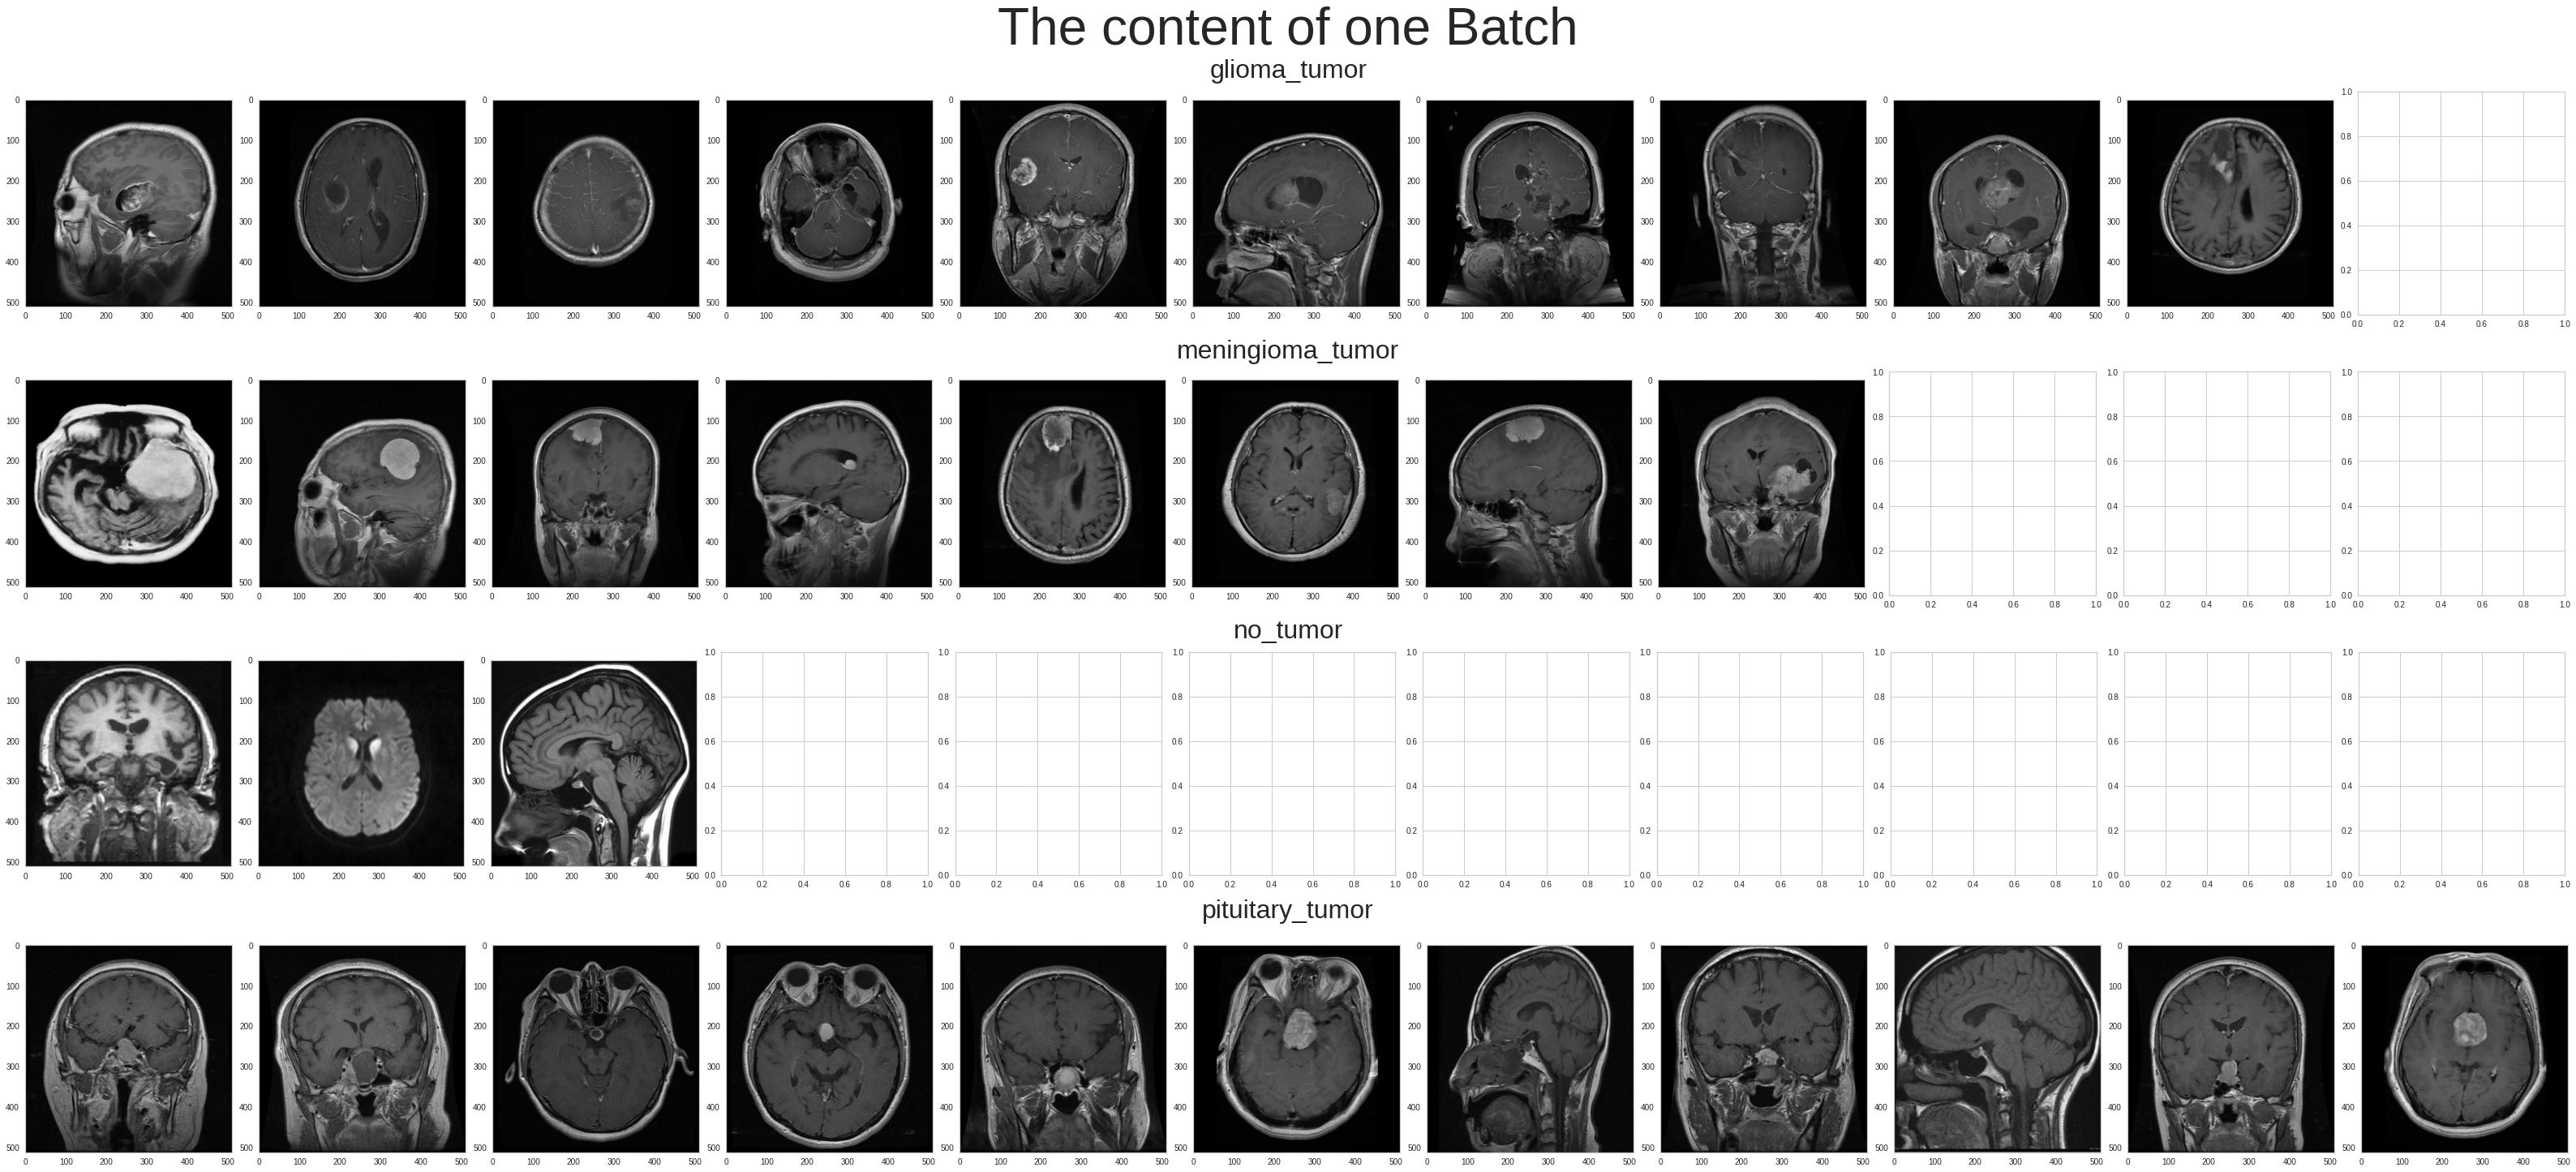

In [15]:
visualize_batch_per_categories(train_ds.take(1))

## Performance configurations

Source: [tensorflow tutorial](https://www.tensorflow.org/tutorials/images/classification)

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Preprocessing

Let's find the range of the color intensities:

In [17]:
def get_sample_image_values_range(ds):
  image_batch, labels_batch = next(iter(ds))
  first_image = image_batch[0]
  # Notice the pixel values are now in `[0,1]`.
  return np.min(first_image), np.max(first_image)

In [18]:
print("Sample image's values' range: ", get_sample_image_values_range(train_ds))

Sample image's values' range:  (0.0, 255.0)


Because neural networks work better with small values, we should scale the [0, 255] pixel color values to [0, 1]. 

In [19]:
def rescale_pixels(ds):
  rescaler = tf.keras.layers.Rescaling(1./255.0)
  return ds.map(lambda x, y: (rescaler(x), y))

In [20]:
train_ds = rescale_pixels(train_ds)
valid_ds = rescale_pixels(valid_ds)
test_ds = rescale_pixels(test_ds)

## Evaluation metrics

Before starting to design and train a machine learning model for classifying MRI images, we should think about what the goal of this classifier is, what is the metric that we want to maximize.

We have shown above, that in most cases, when an MRI suggests that a patient might have a brain tumor, then a biopsy is made to get more information about the tumor's type (bening or malignant), grade (aggressiveness), etc. This is especially true when the chance of a ,alignant tumor is higher, but for pituitary tumors an MRI may sometimes be enough for a full diagnosis, together with a medical background check.

This suggests that **detecting that a paient has a tumor is of a higher importance than classifying the tumor**: fortunately, a brain biopsy, though invasive, is considered a very safe procedure nowadays, so the cost of sending a patient to an unnecessary biopsy is far less then not detecting a tumor and letting it grow and possibly spread over time, as tumors are generally far easier to treat in the early stages. Thus, first of all, **we should maximize the precision for the *no_tumor* class**: we want that all MRIs categorized as no_tumor actually belong to patients who have no tumor, and no patient is mistakenly said they they're healthy if this is not the case.

**However, misclassifications among the 3 tumor classes still matter**: it is of utter importance to know as soon as possible whether a tumor is bening (usually the pituitary tumors, sometimes even meningiomas) or malignant (usually the gliomas, sometimes meningiomas). People with a malignant tumor need urgent treatment before the tumor starts to grow and spread, whereas for bening tumors a "wait and see" strategy is often the best choice. Thus, **we should try to maximize the weighted, balanced accuracy = the average recall obtained on each class**. Note that we use a weighted accuracy instead of a simple one in order to overcome the issue of having a slightly imbalanced dataset.

To combine the two metrics outlined above, we'll simply take their average.


In [21]:
no_tumor_precision_weight = 0.5

def get_custom_model_score(y_true, y_pred):
  p1 = precision_score(y_true, y_pred, labels = [2], average = None)[0]
  p2 = balanced_accuracy_score(y_true, y_pred)
  return p1 * no_tumor_precision_weight + p2 * (1 - no_tumor_precision_weight)

## Creating models

### Helper functions

In [22]:
def plot_loss_accuracy_history(history):
  plt.figure(figsize=(16, 8))

  plt.subplot(1, 2, 1)
  plt.plot(pd.DataFrame(history.history['accuracy']))
  plt.plot(pd.DataFrame(history.history['val_accuracy']))
  plt.grid(True)
  plt.title("Accuracy")
  plt.gca().legend(('training accuracy', 'validation accuracy'))

  plt.subplot(1, 2, 2)
  plt.plot(pd.DataFrame(history.history['loss']))
  plt.plot(pd.DataFrame(history.history['val_loss']))
  plt.grid(True)
  plt.title("Loss")
  plt.gca().legend(('training loss', 'validation loss'))
  plt.show()

In [23]:
def get_images_labels_from_ds(ds):
  images = np.concatenate([x for x, y in ds], axis=0)
  labels = np.concatenate([y for x, y in ds], axis=0)
  return images, labels

In [24]:
def get_label_predictions(images, model, softmax=False):
  pred_raw = model.predict(images)
  pred_class = [np.int64(np.argmax(prob)) for prob in pred_raw]
  return pred_class

In [25]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
  conf_mat = confusion_matrix(y_true, y_pred)
  cm_df = pd.DataFrame(conf_mat,
                     index = class_names, 
                     columns = class_names)
  plt.figure(figsize=(8,6))
  g = sns.heatmap(cm_df, annot=True, fmt='.4g')
  plt.title(title, fontsize=18)
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  # g.set_yticklabels(g.get_yticklabels(), rotation = 30, fontsize = 12)
  g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12)
  plt.show()

In [26]:
def print_classification_metrics(y_true, y_pred):
  print(classification_report(y_true, y_pred, target_names=class_names))

In [27]:
def show_full_classification_report(model, ds, model_name, softmax=False):
  x_images, y_true = get_images_labels_from_ds(ds)
  y_pred = get_label_predictions(x_images, model, softmax=softmax)
  plot_confusion_matrix(y_true, y_pred, "Confusion matrix for the " + model_name)
  print_classification_metrics(y_true, y_pred)
  print("---- FINAL SCORE (CUSTOM FORMULA) ", get_custom_model_score(y_true, y_pred))

In [28]:
num_classes = len(class_names)

In [29]:
valid_images, valid_labels = get_images_labels_from_ds(valid_ds)

## Transfer learning

### Preprocessing

In [ ]:
def to_rgb(image):
    image = tf.image.grayscale_to_rgb(image)
    # image = tf.image.resize(image, [IMAGE_SIZE[0], IMAGE_SIZE[1]])
    return image

In [ ]:
def convert_dataset_to_rgb(ds):
  return ds.map(lambda x, y: (to_rgb(x), y))

In [ ]:
train_ds_rgb = convert_dataset_to_rgb(train_ds)
valid_ds_rgb = convert_dataset_to_rgb(valid_ds)
test_ds_rgb = convert_dataset_to_rgb(test_ds)

In [ ]:
def resize_images(image, new_x, new_y):
    image = tf.image.resize(image, [new_x, new_y])
    return image

In [ ]:
def rezise_images_from_dataset(ds, new_size_x, new_size_y):
  return ds.map(lambda x, y: (resize_images(x, new_size_x, new_size_y), y))

In [ ]:
train_ds_rgb_resized = rezise_images_from_dataset(train_ds_rgb, 224, 224)
valid_ds_rgb_resized = rezise_images_from_dataset(valid_ds_rgb, 224, 224)
test_ds_rgb_resized = rezise_images_from_dataset(test_ds_rgb, 224, 224)

### InceptionV3 

In [ ]:
pretrained_base = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=max
)
pretrained_base.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
model_inception = Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
model_inception.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 32)                12845088  
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 34,649,060
Trainable params: 12,846,276
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('inception_model.h5', monitor='val_accuracy', mode='max')

history = model_inception.fit(
    train_ds_rgb,
    validation_data=valid_ds_rgb,
    epochs=30,
    callbacks=[es, mc]
)

Epoch 1/30
72/72 [==============================] - 156s 2s/step - loss: 5.2856 - accuracy: 0.6977 - val_loss: 1.4993 - val_accuracy: 0.7683
Epoch 2/30
72/72 [==============================] - 108s 2s/step - loss: 0.3868 - accuracy: 0.9242 - val_loss: 0.8675 - val_accuracy: 0.9007
Epoch 3/30
72/72 [==============================] - 109s 2s/step - loss: 0.0855 - accuracy: 0.9708 - val_loss: 1.2084 - val_accuracy: 0.8728
Epoch 4/30
72/72 [==============================] - 108s 2s/step - loss: 0.0548 - accuracy: 0.9856 - val_loss: 1.0698 - val_accuracy: 0.8920
Epoch 5/30
72/72 [==============================] - 109s 2s/step - loss: 0.1090 - accuracy: 0.9756 - val_loss: 1.1927 - val_accuracy: 0.8920
Epoch 6/30
72/72 [==============================] - 110s 2s/step - loss: 0.1739 - accuracy: 0.9682 - val_loss: 1.2209 - val_accuracy: 0.8728
Epoch 7/30
72/72 [==============================] - 118s 2s/step - loss: 0.0288 - accuracy: 0.9922 - val_loss: 1.6592 - val_accuracy: 0.8798
Epoch 8/30
72

In [ ]:
model_inception.save_weights('inception_model_weights_only.h5')

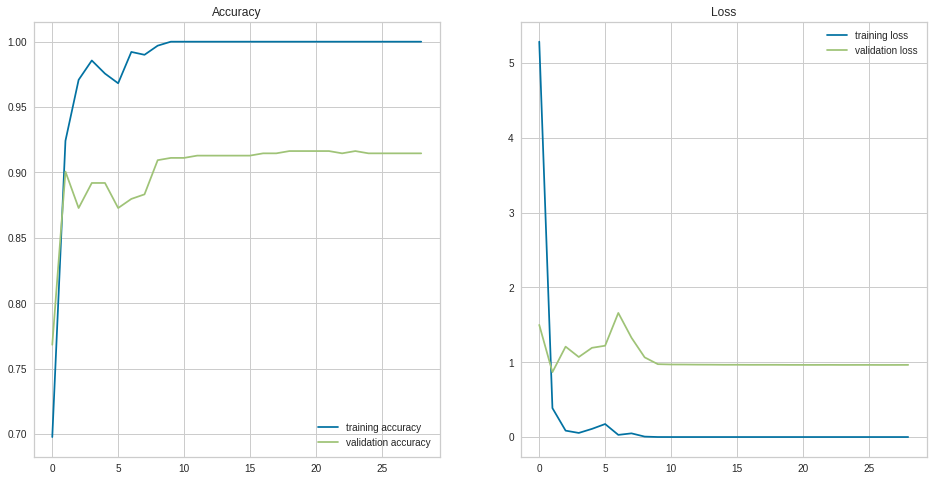

In [ ]:
plot_loss_accuracy_history(history)

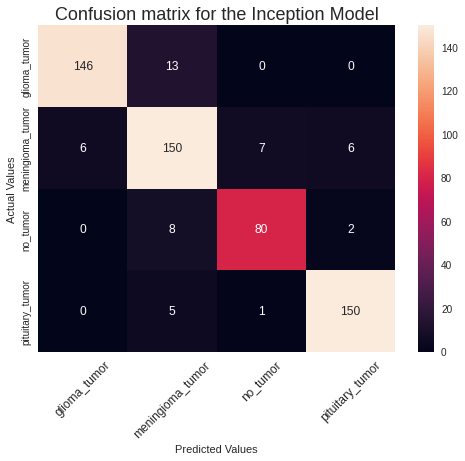

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.92      0.94       159
meningioma_tumor       0.85      0.89      0.87       169
        no_tumor       0.91      0.89      0.90        90
 pituitary_tumor       0.95      0.96      0.96       156

        accuracy                           0.92       574
       macro avg       0.92      0.91      0.92       574
    weighted avg       0.92      0.92      0.92       574

---- FINAL SCORE (CUSTOM FORMULA)  0.91157549312484


In [ ]:
show_full_classification_report(model_inception, valid_ds_rgb, "Inception Model")

### ResNet50 

In [ ]:
def resnet_preprocessing(ds):
  return ds.map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x * 255), y))

In [ ]:
train_ds_resnet = resnet_preprocessing(train_ds_rgb_resized)
valid_ds_resnet = resnet_preprocessing(valid_ds_rgb_resized)
test_ds_resnet = resnet_preprocessing(test_ds_rgb_resized)

In [ ]:
pretrained_base_resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling=max
)
pretrained_base_resnet.trainable = False

In [ ]:
model_resnet = Sequential([
    pretrained_base_resnet,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
model_resnet.compile(
    optimizer=tf.optimizers.SGD(lr=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 32)                3211296   
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 4)                 132       
                                                                 
Total params: 26,800,196
Trainable params: 3,212,484
Non-trainable params: 23,587,712
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('resnet_model.h5', monitor='val_accuracy', mode='max')

history = model_resnet.fit(
    train_ds_resnet,
    validation_data=valid_ds_resnet,
    epochs=50,
    callbacks=[es, mc]
)

Epoch 1/50
72/72 [==============================] - 21s 222ms/step - loss: 0.8241 - accuracy: 0.6877 - val_loss: 0.5207 - val_accuracy: 0.7753
Epoch 2/50
72/72 [==============================] - 15s 207ms/step - loss: 0.3581 - accuracy: 0.8619 - val_loss: 0.4759 - val_accuracy: 0.7927
Epoch 3/50
72/72 [==============================] - 17s 238ms/step - loss: 0.2234 - accuracy: 0.9172 - val_loss: 0.3150 - val_accuracy: 0.8711
Epoch 4/50
72/72 [==============================] - 15s 207ms/step - loss: 0.1665 - accuracy: 0.9425 - val_loss: 0.2899 - val_accuracy: 0.8868
Epoch 5/50
72/72 [==============================] - 15s 207ms/step - loss: 0.1217 - accuracy: 0.9639 - val_loss: 0.2679 - val_accuracy: 0.9024
Epoch 6/50
72/72 [==============================] - 16s 213ms/step - loss: 0.0833 - accuracy: 0.9830 - val_loss: 0.2609 - val_accuracy: 0.9024
Epoch 7/50
72/72 [==============================] - 15s 207ms/step - loss: 0.0619 - accuracy: 0.9895 - val_loss: 0.2467 - val_accuracy: 0.9111

In [ ]:
model_resnet.save_weights('resnet_model_weights_only.h5')

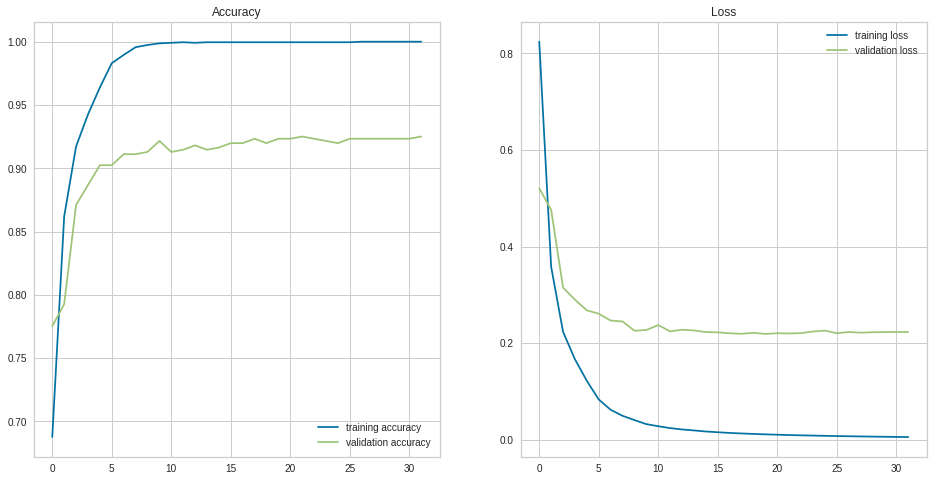

In [ ]:
plot_loss_accuracy_history(history)

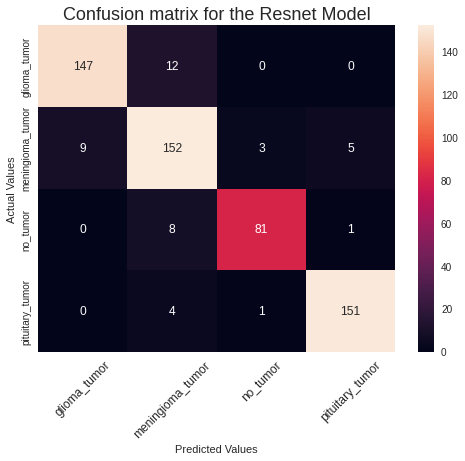

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.92      0.93       159
meningioma_tumor       0.86      0.90      0.88       169
        no_tumor       0.95      0.90      0.93        90
 pituitary_tumor       0.96      0.97      0.96       156

        accuracy                           0.93       574
       macro avg       0.93      0.92      0.93       574
    weighted avg       0.93      0.93      0.93       574

---- FINAL SCORE (CUSTOM FORMULA)  0.9379562512176916


In [ ]:
show_full_classification_report(model_resnet, valid_ds_resnet, "Resnet Model")

### VGG16

In [ ]:
pretrained_base_vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights=None,
    input_shape=(224, 224, 3),
    pooling=max
)
pretrained_base_vgg.trainable = False

In [ ]:
model_vgg = Sequential([
    pretrained_base_vgg,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_vgg.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 15,518,724
Trainable params: 804,036
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('vgg_model.h5', monitor='val_accuracy', mode='max')

history_vgg = model_vgg.fit(
    train_ds_rgb_resized,
    validation_data=valid_ds_rgb_resized,
    epochs=100,
    callbacks=[es, mc]
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


72/72 [==============================] - 32s 365ms/step - loss: 1.3528 - accuracy: 0.3384 - val_loss: 1.3322 - val_accuracy: 0.4355
Epoch 2/100
72/72 [==============================] - 22s 300ms/step - loss: 1.2668 - accuracy: 0.4669 - val_loss: 1.2485 - val_accuracy: 0.4495
Epoch 3/100
72/72 [==============================] - 22s 302ms/step - loss: 1.1721 - accuracy: 0.5213 - val_loss: 1.1722 - val_accuracy: 0.5557
Epoch 4/100
72/72 [==============================] - 22s 306ms/step - loss: 1.1048 - accuracy: 0.5518 - val_loss: 1.1219 - val_accuracy: 0.5436
Epoch 5/100
72/72 [==============================] - 22s 304ms/step - loss: 1.0537 - accuracy: 0.5662 - val_loss: 1.0809 - val_accuracy: 0.5714
Epoch 6/100
72/72 [==============================] - 22s 306ms/step - loss: 1.0038 - accuracy: 0.5854 - val_loss: 1.0324 - val_accuracy: 0.5314
Epoch 7/100
72/72 [==============================] - 22s 306ms/step - loss: 0.9531 - accuracy: 0.5897 - val_loss: 0.9935 - val_accuracy: 0.5610
Epoc

In [ ]:
model_vgg.save_weights('vgg_model_weights_only.h5')

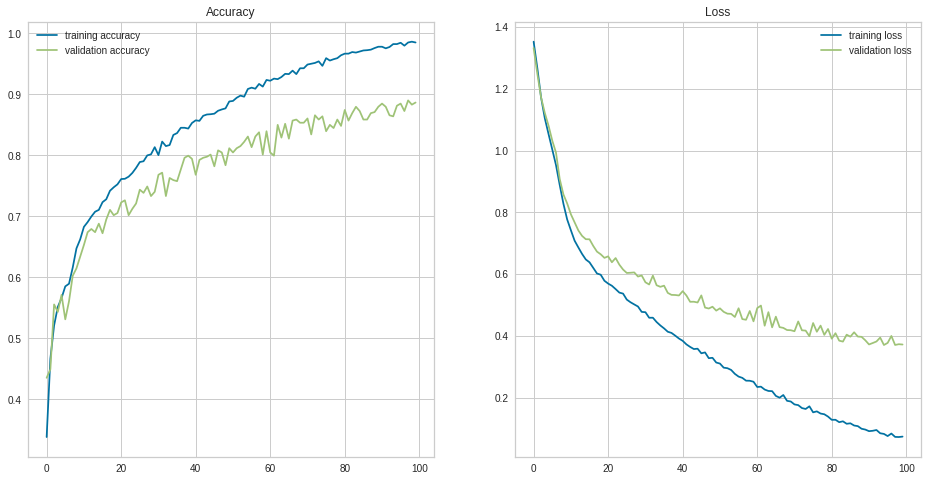

In [ ]:
plot_loss_accuracy_history(history_vgg)

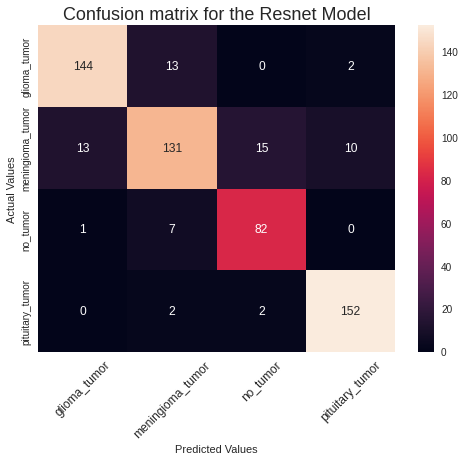

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.91      0.91       159
meningioma_tumor       0.86      0.78      0.81       169
        no_tumor       0.83      0.91      0.87        90
 pituitary_tumor       0.93      0.97      0.95       156

        accuracy                           0.89       574
       macro avg       0.88      0.89      0.88       574
    weighted avg       0.89      0.89      0.89       574

---- FINAL SCORE (CUSTOM FORMULA)  0.8599262131192464


In [ ]:
show_full_classification_report(model_vgg, valid_ds_rgb_resized, "Vgg Model")

### AlexNet

In [ ]:
train_ds_alexnet = rezise_images_from_dataset(train_ds_rgb, 227, 227)
valid_ds_alexnet = rezise_images_from_dataset(valid_ds_rgb, 227, 227)
test_ds_alexnet = rezise_images_from_dataset(test_ds_rgb, 227, 227)

In [ ]:
model_alexnet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_alexnet.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model_alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('alexnet_model.h5', monitor='val_accuracy', mode='max')

history_alexnet = model_alexnet.fit(
    train_ds_alexnet,
    validation_data=valid_ds_alexnet,
    epochs=50,
    callbacks=[es, mc]
)

Epoch 1/50
72/72 [==============================] - 24s 165ms/step - loss: 2.0777 - accuracy: 0.4739 - val_loss: 2.0831 - val_accuracy: 0.2718
Epoch 2/50
72/72 [==============================] - 11s 157ms/step - loss: 1.1224 - accuracy: 0.6337 - val_loss: 1.8772 - val_accuracy: 0.2718
Epoch 3/50
72/72 [==============================] - 20s 282ms/step - loss: 0.9384 - accuracy: 0.6821 - val_loss: 1.8581 - val_accuracy: 0.2962
Epoch 4/50
72/72 [==============================] - 16s 224ms/step - loss: 0.8049 - accuracy: 0.7051 - val_loss: 1.6124 - val_accuracy: 0.3780
Epoch 5/50
72/72 [==============================] - 18s 245ms/step - loss: 0.6469 - accuracy: 0.7735 - val_loss: 1.2303 - val_accuracy: 0.5557
Epoch 6/50
72/72 [==============================] - 17s 237ms/step - loss: 0.5762 - accuracy: 0.7844 - val_loss: 1.0768 - val_accuracy: 0.6307
Epoch 7/50
72/72 [==============================] - 10s 141ms/step - loss: 0.5205 - accuracy: 0.7992 - val_loss: 0.7630 - val_accuracy: 0.6951

In [ ]:
model_alexnet.save_weights('alexnet_model_weights_only.h5')

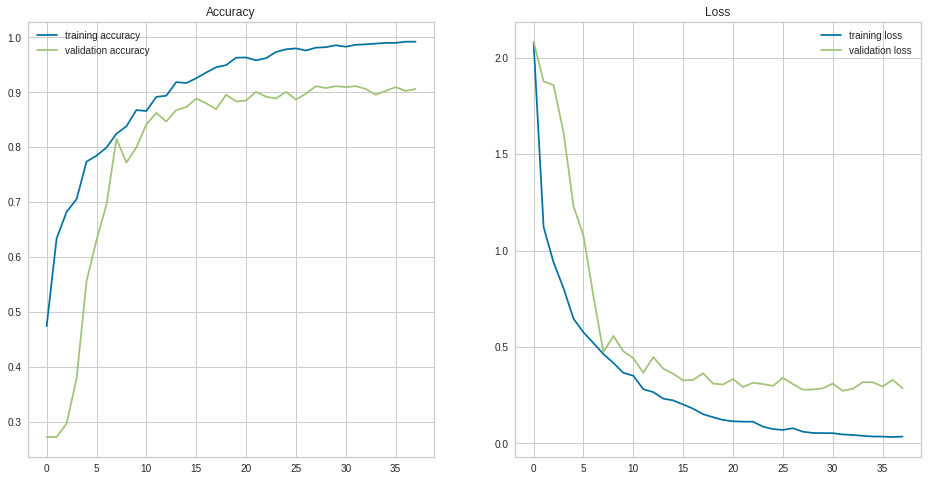

In [ ]:
plot_loss_accuracy_history(history_alexnet)

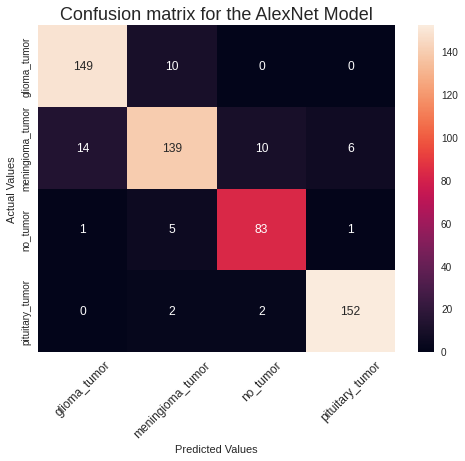

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.94      0.92       159
meningioma_tumor       0.89      0.82      0.86       169
        no_tumor       0.87      0.92      0.90        90
 pituitary_tumor       0.96      0.97      0.97       156

        accuracy                           0.91       574
       macro avg       0.91      0.91      0.91       574
    weighted avg       0.91      0.91      0.91       574

---- FINAL SCORE (CUSTOM FORMULA)  0.8938637705032557


In [ ]:
show_full_classification_report(model_alexnet, valid_ds_alexnet, "AlexNet Model")

### AlexNet with Adam

In [ ]:
model_alexnet.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

model_alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('alexnet_model2.h5', monitor='val_accuracy', mode='max')

history_alexnet2 = model_alexnet.fit(
    train_ds_alexnet,
    validation_data=valid_ds_alexnet,
    epochs=50,
    callbacks=[es, mc]
)

Epoch 1/50
72/72 [==============================] - 14s 173ms/step - loss: 9.2978 - accuracy: 0.4983 - val_loss: 6.4669 - val_accuracy: 0.2125
Epoch 2/50
72/72 [==============================] - 15s 208ms/step - loss: 1.2471 - accuracy: 0.5632 - val_loss: 1.0222 - val_accuracy: 0.6063
Epoch 3/50
72/72 [==============================] - 12s 170ms/step - loss: 1.0906 - accuracy: 0.5841 - val_loss: 1.2359 - val_accuracy: 0.5139
Epoch 4/50
72/72 [==============================] - 12s 166ms/step - loss: 1.0672 - accuracy: 0.5862 - val_loss: 1.2632 - val_accuracy: 0.4878
Epoch 5/50
72/72 [==============================] - 13s 174ms/step - loss: 1.0424 - accuracy: 0.5967 - val_loss: 0.9674 - val_accuracy: 0.6098
Epoch 6/50
72/72 [==============================] - 12s 171ms/step - loss: 1.0496 - accuracy: 0.5658 - val_loss: 0.9656 - val_accuracy: 0.6341
Epoch 7/50
72/72 [==============================] - 12s 169ms/step - loss: 0.9854 - accuracy: 0.6163 - val_loss: 0.9340 - val_accuracy: 0.6481

In [ ]:
model_alexnet.save_weights('alexnet_model2_weights_only.h5')

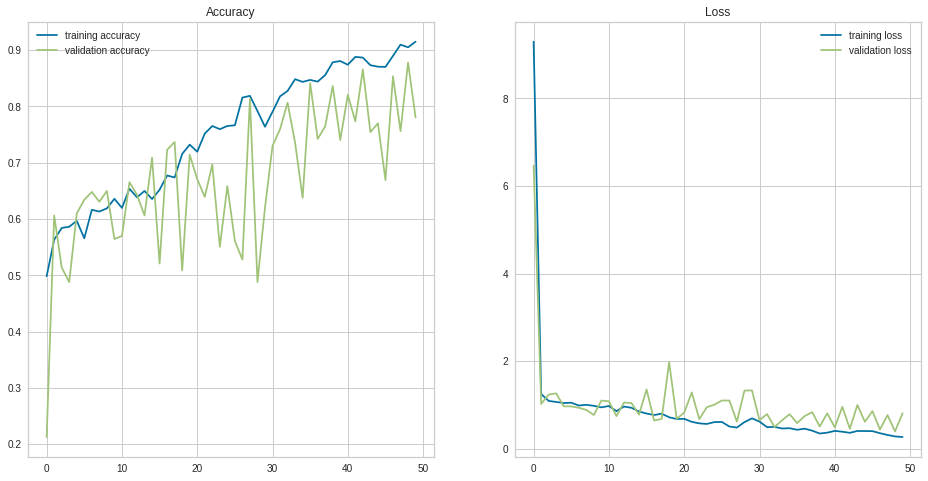

In [ ]:
plot_loss_accuracy_history(history_alexnet2)

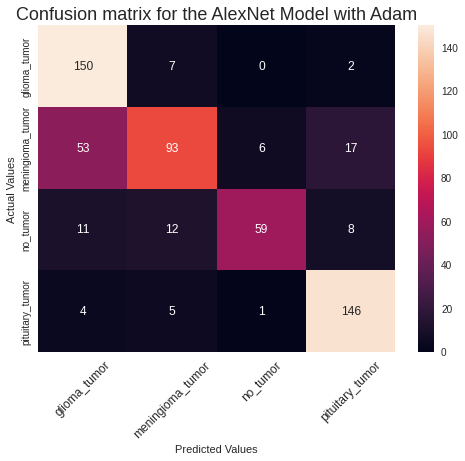

                  precision    recall  f1-score   support

    glioma_tumor       0.69      0.94      0.80       159
meningioma_tumor       0.79      0.55      0.65       169
        no_tumor       0.89      0.66      0.76        90
 pituitary_tumor       0.84      0.94      0.89       156

        accuracy                           0.78       574
       macro avg       0.81      0.77      0.77       574
    weighted avg       0.79      0.78      0.77       574

---- FINAL SCORE (CUSTOM FORMULA)  0.8326128314517285


In [ ]:
show_full_classification_report(model_alexnet, valid_ds_alexnet, "AlexNet Model with Adam")

## Creating our own Model (Tensorflow CNN)

### Initial Model

We'll start with a very simple initial model, consisting of only one convolutional and one dense layer. This model is not expeccted to produce good results, but we consider it rather an experiment.

In [ ]:
model1 = Sequential([
  # layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 32)                33554464  
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 33,554,756
Trainable params: 33,554,756
Non-trainable params: 0
____________________________________________

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
mc = ModelCheckpoint('initial_model.h5', monitor='val_accuracy', mode='max')

set_seed()

max_epochs=30
history1 = model1.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc]
)

Epoch 1/30
72/72 [==============================] - 29s 206ms/step - loss: 3.6274 - accuracy: 0.5196 - val_loss: 0.9449 - val_accuracy: 0.6498
Epoch 2/30
72/72 [==============================] - 14s 196ms/step - loss: 0.6633 - accuracy: 0.7626 - val_loss: 0.7159 - val_accuracy: 0.7387
Epoch 3/30
72/72 [==============================] - 14s 198ms/step - loss: 0.3589 - accuracy: 0.8924 - val_loss: 0.6395 - val_accuracy: 0.7718
Epoch 4/30
72/72 [==============================] - 14s 198ms/step - loss: 0.2060 - accuracy: 0.9395 - val_loss: 0.5580 - val_accuracy: 0.8049
Epoch 5/30
72/72 [==============================] - 14s 198ms/step - loss: 0.0931 - accuracy: 0.9804 - val_loss: 0.5090 - val_accuracy: 0.8275
Epoch 6/30
72/72 [==============================] - 14s 199ms/step - loss: 0.0449 - accuracy: 0.9952 - val_loss: 0.5355 - val_accuracy: 0.8153
Epoch 7/30
72/72 [==============================] - 14s 200ms/step - loss: 0.0277 - accuracy: 0.9978 - val_loss: 0.5340 - val_accuracy: 0.8240

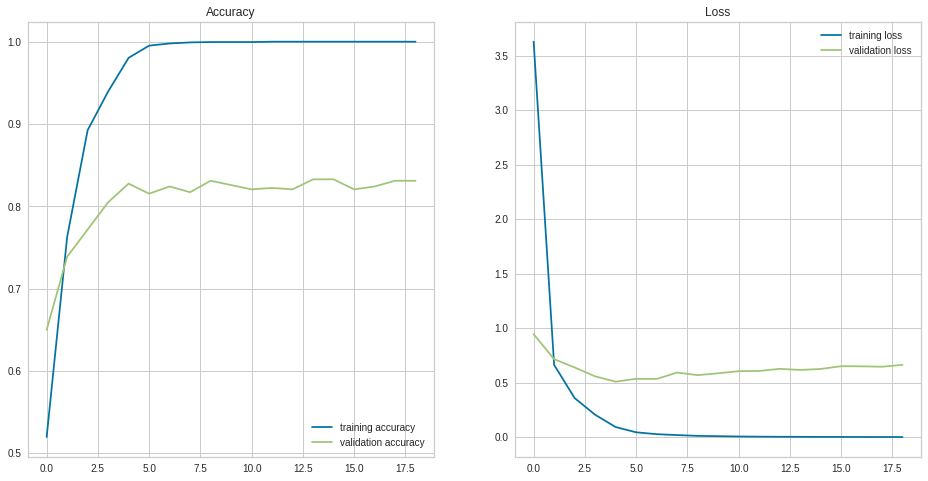

In [ ]:
plot_loss_accuracy_history(history1)

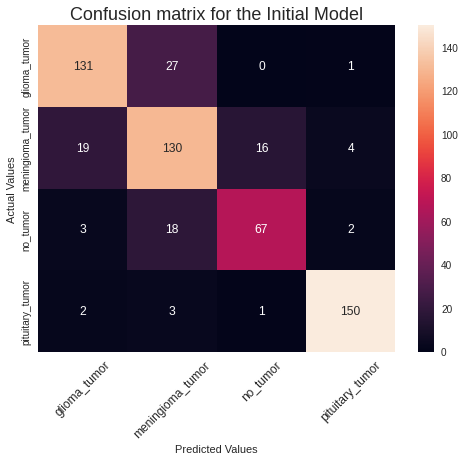

                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.82      0.83       159
meningioma_tumor       0.73      0.77      0.75       169
        no_tumor       0.80      0.74      0.77        90
 pituitary_tumor       0.96      0.96      0.96       156

        accuracy                           0.83       574
       macro avg       0.83      0.82      0.83       574
    weighted avg       0.83      0.83      0.83       574

---- FINAL SCORE (CUSTOM FORMULA)  0.811198654594881


In [ ]:
show_full_classification_report(model1, valid_ds, "Initial Model")

Overall, this ultra-simple model performed surprisingly well: reaching a 0.83 accuracy and falsely labelling a patient as healthy in only 20% of the cases is a result that an untrained human eye probably could not reproduce.

We may ask ourselved the question, how one single convolutional layer could detect such a complex pattern, as a tumor in the brain. The key to the answer lies in the fact that **this model is not that simple actually**, as it has an enormous amount of trainable parameters (33 million). This many parameters are apparently more than enough to perfectly decsribe the training dataset. 

However, there is a huge gap (almost 20%) between the training and the validation accuracy, which suggests that the model has in fact **overfitted the training dataset, but does not generalize well**. Indeed, 33 million parameters are enough to learn any images, but they are in themselves not enough to extract general characteristics of the classes.

Although there are many well-known approaches to solve overfitting specifically, first let's try to optimize the architecture of the network.

### Deeper Model 1 (model2)

As a next step, we'll build a deeper model with 3 convolutional and 2 dense layers. The 3 convolutional layers are already capable of recognizing patterns of 7*7 size, which allwos us to expect a significantly better result than with the previous network.

In [ ]:
model2 = Sequential([
  # layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)      

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True,)
mc = ModelCheckpoint('deeper_model1.h5', monitor='val_accuracy', mode='max')

set_seed()

max_epochs=30
history2 = model2.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc]
)

Epoch 1/30
72/72 [==============================] - 25s 318ms/step - loss: 0.9702 - accuracy: 0.5775 - val_loss: 0.7097 - val_accuracy: 0.6794
Epoch 2/30
72/72 [==============================] - 21s 290ms/step - loss: 0.5353 - accuracy: 0.7766 - val_loss: 0.5493 - val_accuracy: 0.7631
Epoch 3/30
72/72 [==============================] - 21s 292ms/step - loss: 0.2991 - accuracy: 0.8754 - val_loss: 0.4808 - val_accuracy: 0.8188
Epoch 4/30
72/72 [==============================] - 21s 292ms/step - loss: 0.1526 - accuracy: 0.9460 - val_loss: 0.4799 - val_accuracy: 0.8606
Epoch 5/30
72/72 [==============================] - 21s 288ms/step - loss: 0.1284 - accuracy: 0.9560 - val_loss: 0.5837 - val_accuracy: 0.8310
Epoch 6/30
72/72 [==============================] - 21s 285ms/step - loss: 0.0574 - accuracy: 0.9804 - val_loss: 0.7455 - val_accuracy: 0.8136
Epoch 7/30
72/72 [==============================] - 21s 287ms/step - loss: 0.0392 - accuracy: 0.9900 - val_loss: 0.7747 - val_accuracy: 0.8293

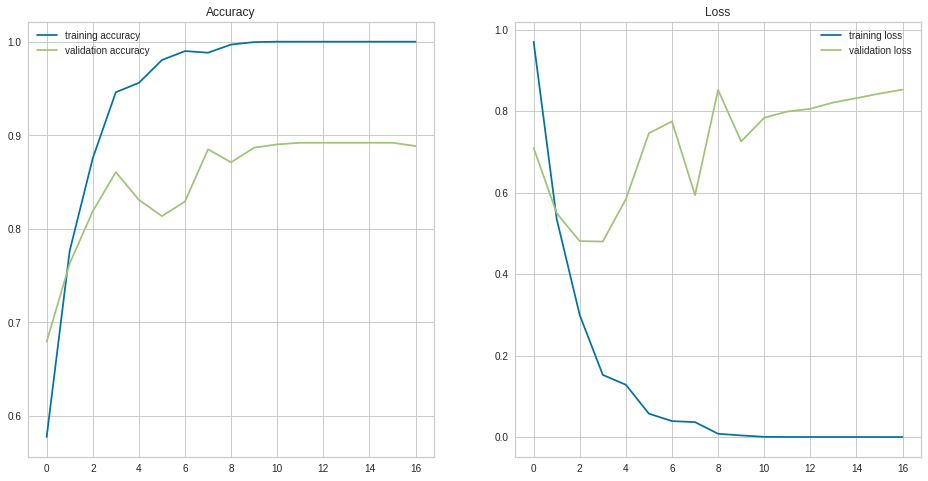

In [ ]:
plot_loss_accuracy_history(history2)

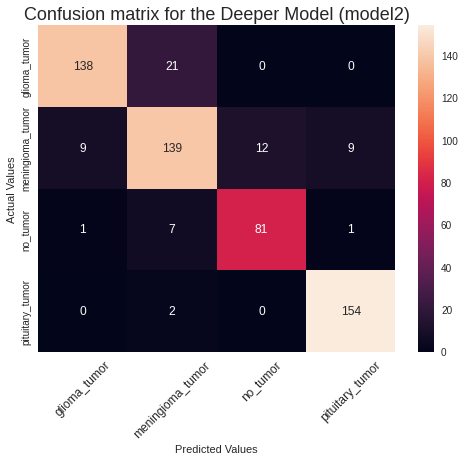

                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.87      0.90       159
meningioma_tumor       0.82      0.82      0.82       169
        no_tumor       0.87      0.90      0.89        90
 pituitary_tumor       0.94      0.99      0.96       156

        accuracy                           0.89       574
       macro avg       0.89      0.89      0.89       574
    weighted avg       0.89      0.89      0.89       574

---- FINAL SCORE (CUSTOM FORMULA)  0.8826825237904876


In [ ]:
show_full_classification_report(model2, valid_ds, "Deeper Model (model2)")

Indeed, we **managed to improve the final score by 7%**: both the no_tumor precision and the balanced accuracy were improved significantly. This proves that the new model generalized better.

However, note that the training accuracy still reached 100%, suggesting that **the model learns too well the training dataset and fails to capture relevant, generic patterns**. 

As deepening the model seems a good approach to address this issue, let's build an even deeper model and see how it behaves.

### Deeper Model 2 (model3)

In [ ]:
model3 = Sequential([
  # layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)      

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True,)
mc = ModelCheckpoint('deeper_model2.h5', monitor='val_accuracy', mode='max')

set_seed()

max_epochs=30
history3 = model3.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc]
)

Epoch 1/30
72/72 [==============================] - 34s 444ms/step - loss: 1.0570 - accuracy: 0.5166 - val_loss: 0.8112 - val_accuracy: 0.6272
Epoch 2/30
72/72 [==============================] - 30s 418ms/step - loss: 0.6757 - accuracy: 0.7021 - val_loss: 0.6105 - val_accuracy: 0.7404
Epoch 3/30
72/72 [==============================] - 30s 420ms/step - loss: 0.4622 - accuracy: 0.8105 - val_loss: 0.5421 - val_accuracy: 0.7927
Epoch 4/30
72/72 [==============================] - 30s 422ms/step - loss: 0.3333 - accuracy: 0.8680 - val_loss: 0.4216 - val_accuracy: 0.8362
Epoch 5/30
72/72 [==============================] - 30s 419ms/step - loss: 0.2340 - accuracy: 0.9085 - val_loss: 0.5364 - val_accuracy: 0.8206
Epoch 6/30
72/72 [==============================] - 30s 421ms/step - loss: 0.1901 - accuracy: 0.9247 - val_loss: 0.7157 - val_accuracy: 0.8345
Epoch 7/30
72/72 [==============================] - 30s 422ms/step - loss: 0.1380 - accuracy: 0.9556 - val_loss: 0.4994 - val_accuracy: 0.8693

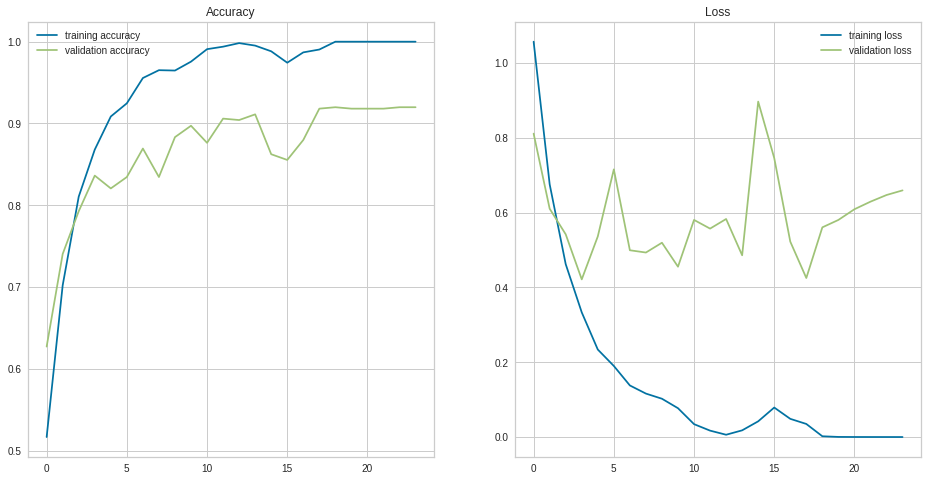

In [ ]:
plot_loss_accuracy_history(history3)

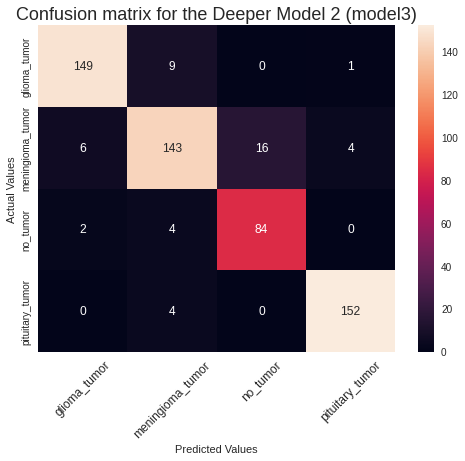

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.94      0.94       159
meningioma_tumor       0.89      0.85      0.87       169
        no_tumor       0.84      0.93      0.88        90
 pituitary_tumor       0.97      0.97      0.97       156

        accuracy                           0.92       574
       macro avg       0.91      0.92      0.92       574
    weighted avg       0.92      0.92      0.92       574

---- FINAL SCORE (CUSTOM FORMULA)  0.8813691340106435


In [ ]:
show_full_classification_report(model3, valid_ds, "Deeper Model 2 (model3)")

This new model has a better overall accuracy, but a reduced precision for the 'no_tumor' class, so overall, the final score is similar to what we achieved before. 

The overfitting was somewhat reduced, but is far from being solved yet. The training accuracy still reached the perfect score of 1, whereas the validation accuracy converged at ~0.92. Let's try now some general techniques for reducing the overfitting:

1.   **apply Dropout**: by randomly setting some input units to 0, some training-specific, but not generalizable patterns will be excluded from the learning process, thus increasing regularization
2.   **apply Data Augmentation**: by forming new, slightly different training samples, we encourage the model to learn the relevant patterns for tumors instead of learning the particularities of the original training images

### Model Regularized with Drouput (model4)

In [ ]:
model4 = Sequential([
  # layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      51264     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 64)      

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True,)
mc = ModelCheckpoint('regularized_model_drouput.h5', monitor='val_accuracy', mode='max')

set_seed()

max_epochs=30
history4 = model4.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc]
)

Epoch 1/30
72/72 [==============================] - 32s 431ms/step - loss: 1.1212 - accuracy: 0.5044 - val_loss: 0.9231 - val_accuracy: 0.5889
Epoch 2/30
72/72 [==============================] - 30s 419ms/step - loss: 0.7529 - accuracy: 0.6908 - val_loss: 0.6926 - val_accuracy: 0.6934
Epoch 3/30
72/72 [==============================] - 30s 421ms/step - loss: 0.5713 - accuracy: 0.7713 - val_loss: 0.6926 - val_accuracy: 0.7003
Epoch 4/30
72/72 [==============================] - 30s 420ms/step - loss: 0.4439 - accuracy: 0.8245 - val_loss: 0.5385 - val_accuracy: 0.7840
Epoch 5/30
72/72 [==============================] - 30s 420ms/step - loss: 0.3637 - accuracy: 0.8563 - val_loss: 0.4680 - val_accuracy: 0.8310
Epoch 6/30
72/72 [==============================] - 30s 419ms/step - loss: 0.2748 - accuracy: 0.8963 - val_loss: 0.4730 - val_accuracy: 0.8258
Epoch 7/30
72/72 [==============================] - 30s 419ms/step - loss: 0.2275 - accuracy: 0.9125 - val_loss: 0.4636 - val_accuracy: 0.8432

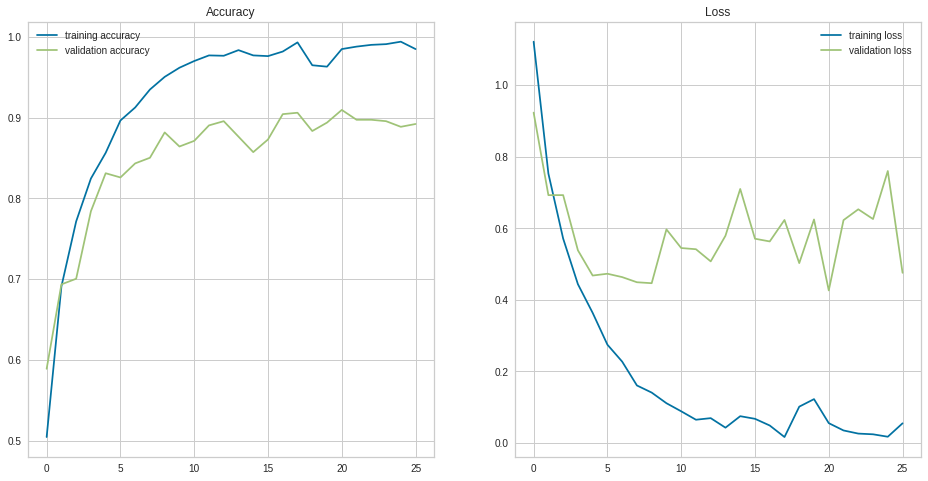

In [ ]:
plot_loss_accuracy_history(history4)

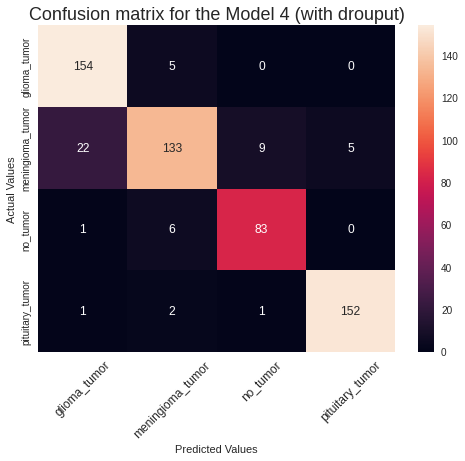

                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.97      0.91       159
meningioma_tumor       0.91      0.79      0.84       169
        no_tumor       0.89      0.92      0.91        90
 pituitary_tumor       0.97      0.97      0.97       156

        accuracy                           0.91       574
       macro avg       0.91      0.91      0.91       574
    weighted avg       0.91      0.91      0.91       574

---- FINAL SCORE (CUSTOM FORMULA)  0.9027511721674604


In [ ]:
show_full_classification_report(model4, valid_ds, "Model 4 (with drouput)")

While the accuracy is somewhat lower, the precision for no tumors has increased, and overall, this is the best model what we have so far.

### Model with Class Weights

We may notice though, that despite of our goal to put more focus on the no_tumor class's precision, the precision of this class is lower than that of the meningioma and pituitary classes. This is not caused simply by the fact that detecting healthy brains would be more difficult: we may recall, that the no_tumor class is signififcantly underrepresented in the training (and in the validation) dataset. To give the no_tumor class more weight in the training process despite having lass samples for it, we could apply balanced class weights while training the DNN.

In [ ]:
model5 = Sequential([
  # layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 256, 256, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 64)      51264     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 64)      

In [ ]:
training_dist = get_distribution(train_ds)

total = np.sum(training_dist)

class_weight = {0: total / training_dist[0],  1: total / training_dist[1], 2: total / training_dist[2], 3: total / training_dist[3]}

class_weight

{0: 3.442278860569715,
 1: 3.5160796324655434,
 2: 7.527868852459016,
 3: 3.421758569299553}

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True,)
mc = ModelCheckpoint('regularized_model_drouput.h5', monitor='val_accuracy', mode='max')

set_seed()

max_epochs=30
history5 = model5.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc],
  class_weight=class_weight
)

Epoch 1/30
72/72 [==============================] - 32s 427ms/step - loss: 4.7687 - accuracy: 0.4569 - val_loss: 0.9930 - val_accuracy: 0.5801
Epoch 2/30
72/72 [==============================] - 30s 420ms/step - loss: 3.0597 - accuracy: 0.6773 - val_loss: 0.6882 - val_accuracy: 0.7178
Epoch 3/30
72/72 [==============================] - 30s 421ms/step - loss: 2.2517 - accuracy: 0.7670 - val_loss: 0.5884 - val_accuracy: 0.7578
Epoch 4/30
72/72 [==============================] - 30s 421ms/step - loss: 1.8037 - accuracy: 0.8214 - val_loss: 0.5324 - val_accuracy: 0.7962
Epoch 5/30
72/72 [==============================] - 30s 420ms/step - loss: 1.3682 - accuracy: 0.8641 - val_loss: 0.5338 - val_accuracy: 0.8014
Epoch 6/30
72/72 [==============================] - 30s 421ms/step - loss: 1.1197 - accuracy: 0.8841 - val_loss: 0.5116 - val_accuracy: 0.8031
Epoch 7/30
72/72 [==============================] - 30s 420ms/step - loss: 0.8994 - accuracy: 0.9077 - val_loss: 0.5453 - val_accuracy: 0.8066

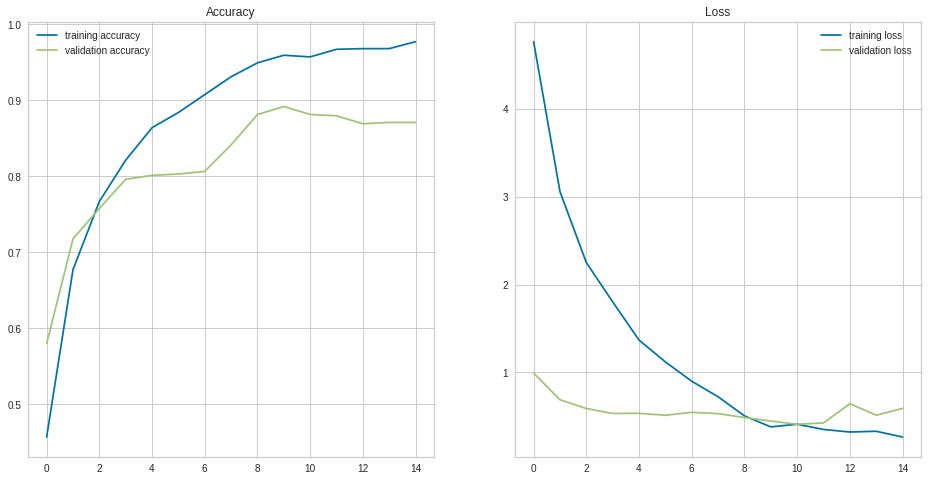

In [ ]:
plot_loss_accuracy_history(history5)

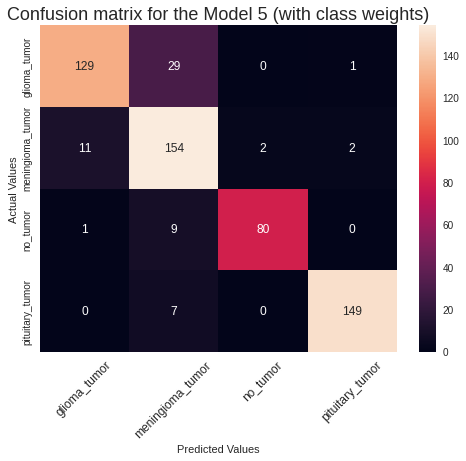

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.81      0.86       159
meningioma_tumor       0.77      0.91      0.84       169
        no_tumor       0.98      0.89      0.93        90
 pituitary_tumor       0.98      0.96      0.97       156

        accuracy                           0.89       574
       macro avg       0.91      0.89      0.90       574
    weighted avg       0.90      0.89      0.89       574

---- FINAL SCORE (CUSTOM FORMULA)  0.9336274345843268


In [ ]:
show_full_classification_report(model5, valid_ds, "Model 5 (with class weights)")

Our intuition was right: by increasing the weight of the no_tumor class (to a balanced value), we could reach a precision of 98% for this class, meaning that only 2% of those said to be healthy by our model have a tumor in reality.

### First Model with Data Augmentation

Now, let's return to the other regularization method: data augmentation. 

Note that the images are quite well-organized: they MRIs are mostly centered and rotated vertically, as expected, and we can only observe slight differences in the dimensions of the brains on the images. To produce more data withough generating significantly different images from what we have (and what we expect to get when a prediction has to be made by the deployed model), we'll apply some minor transformations:
*   horizontal flippings
*   rotations (+-10 degrees)
*   OX/OY translations (+-5%)
*   Zoom-in/Zoom-out (+-5%)

It is critical that we do not apply any transformations that would make the tumor to be cropped from the image, so larger translations and zoom-ins are not possible.

In [30]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(
      factor = (-0.027, 0.027), # 10 degrees
      fill_mode = 'constant'
  ),
  layers.RandomTranslation(
    height_factor = (-0.05, 0.05),
    width_factor = (-0.05, 0.05),
    fill_mode='constant',
  ),
  layers.RandomZoom(
    height_factor = (-0.05, 0.05),
    width_factor = (-0.05, 0.05),
    fill_mode='constant'
  )
])

Some sample augmented images can be seen in the next cell:

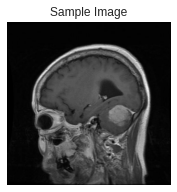

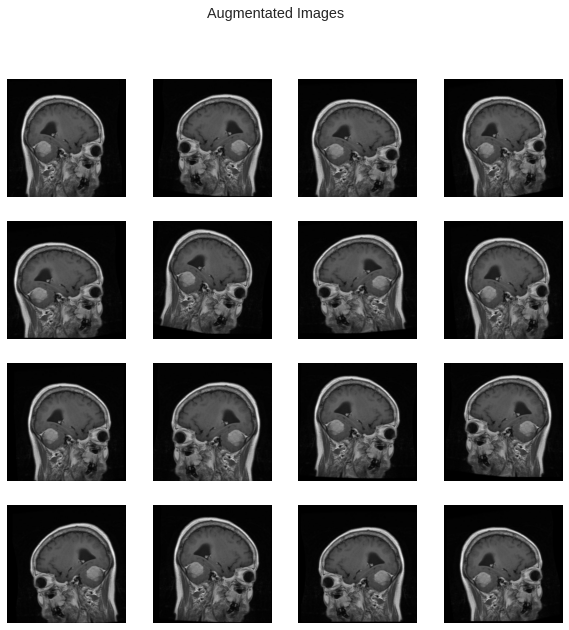

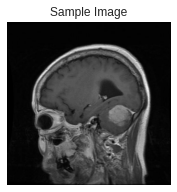

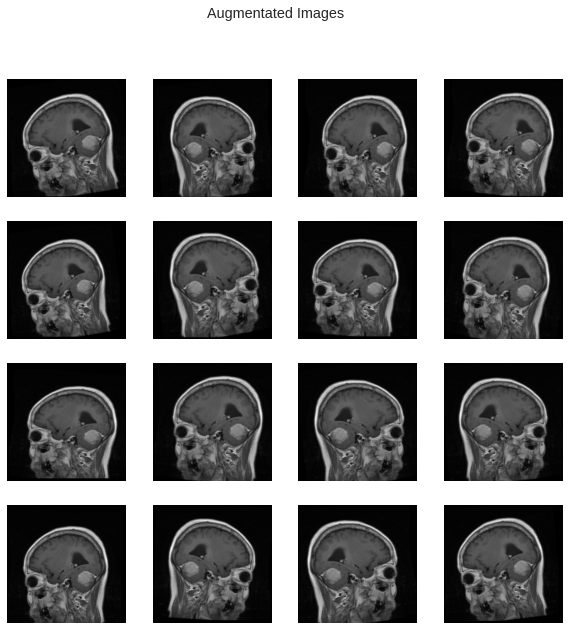

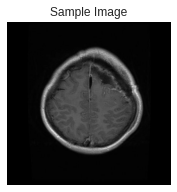

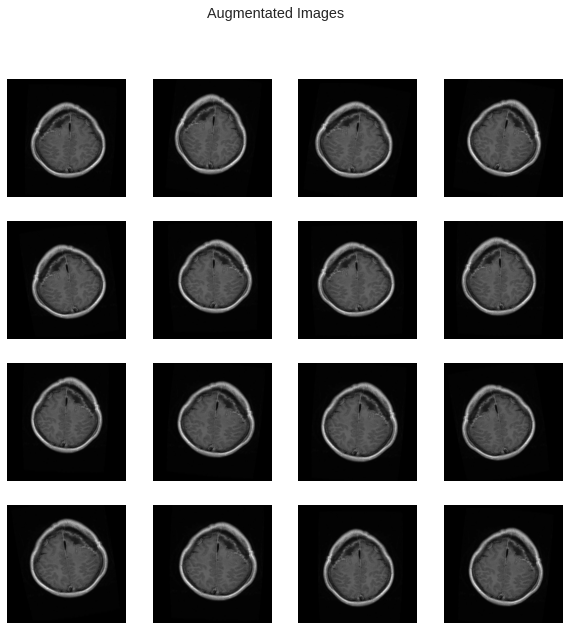

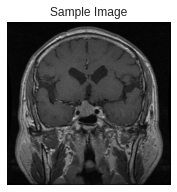

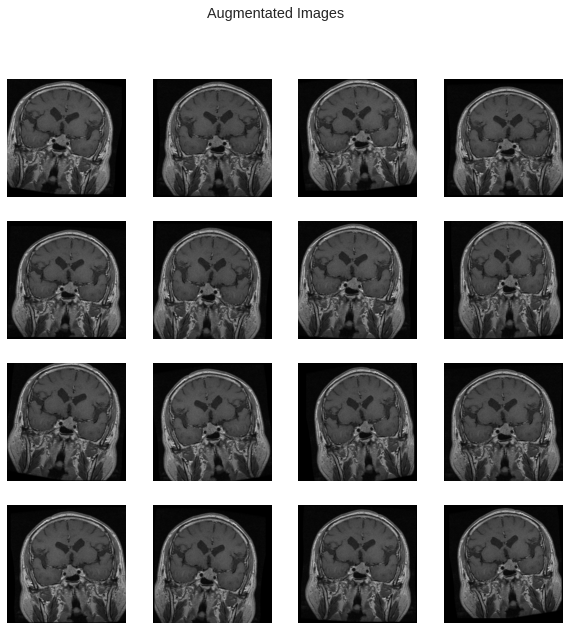

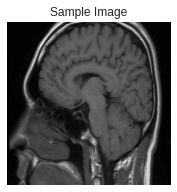

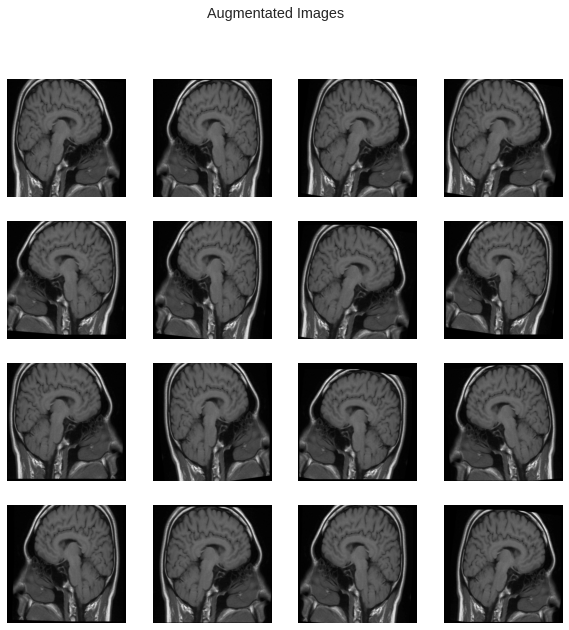

In [ ]:
for index in range(5):
  ex = next(iter(train_ds.unbatch().map(lambda x, y: x).batch(1)))

  plt.figure(figsize=(3, 3))
  plt.title("Sample Image")
  plt.imshow(tf.squeeze(ex), cmap='gray')
  plt.axis('off')

  plt.figure(figsize=(10,10))
  plt.suptitle("Augmentated Images")
  for i in range(16):
      image = data_augmentation(ex, training=True)
      plt.subplot(4, 4, i+1)
      plt.imshow(tf.squeeze(image), cmap='gray')
      plt.axis('off')

  plt.show()

In [ ]:
model6 = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes, activation=tf.nn.softmax)
])


model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model6.build(input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)     

As we are getting close to building our final model, we'll set a higher patience and a longer training time (100 epochs). 

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20, restore_best_weights=True)
mc = ModelCheckpoint('data_augmentation_model.h5', monitor='val_accuracy', mode='max')

set_seed()

training_dist = get_distribution(train_ds)
total = np.sum(training_dist)
class_weight = {0: total / training_dist[0],  1: total / training_dist[1], 2: total / training_dist[2], 3: total / training_dist[3]}
class_weight

max_epochs=100
history6 = model6.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc],
  class_weight = class_weight
)

Epoch 1/100
72/72 [==============================] - 46s 434ms/step - loss: 4.7781 - accuracy: 0.4486 - val_loss: 1.0752 - val_accuracy: 0.5470
Epoch 2/100
72/72 [==============================] - 29s 409ms/step - loss: 3.5311 - accuracy: 0.6054 - val_loss: 0.9203 - val_accuracy: 0.6446
Epoch 3/100
72/72 [==============================] - 30s 413ms/step - loss: 3.0996 - accuracy: 0.6633 - val_loss: 0.6982 - val_accuracy: 0.7125
Epoch 4/100
72/72 [==============================] - 30s 420ms/step - loss: 2.6252 - accuracy: 0.7199 - val_loss: 0.5899 - val_accuracy: 0.7596
Epoch 5/100
72/72 [==============================] - 31s 428ms/step - loss: 2.4604 - accuracy: 0.7382 - val_loss: 0.6180 - val_accuracy: 0.7334
Epoch 6/100
72/72 [==============================] - 31s 427ms/step - loss: 2.0807 - accuracy: 0.7770 - val_loss: 0.5845 - val_accuracy: 0.7718
Epoch 7/100
72/72 [==============================] - 31s 427ms/step - loss: 2.0111 - accuracy: 0.7901 - val_loss: 0.5661 - val_accuracy:

In [ ]:
model6.save_weights('data_augmentation_model_weights_only.h5')

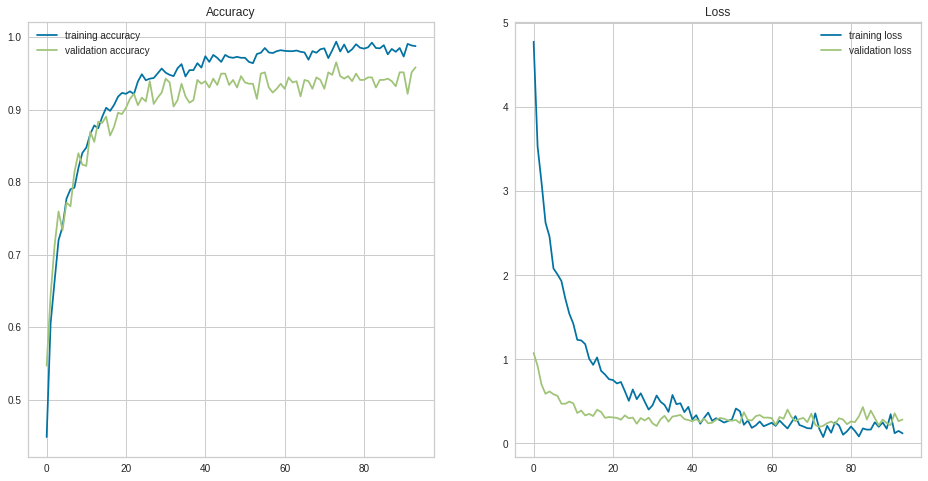

In [ ]:
plot_loss_accuracy_history(history6)

Remark that the longer training time was justified: this model indeed didn't suffer from a significant overfitting, the training- and validation accuracy and losses were progressing close to each other, unlike in case of the previus networks, were the training accuracy quickly reached 100%, and thus no room was left for improvements.

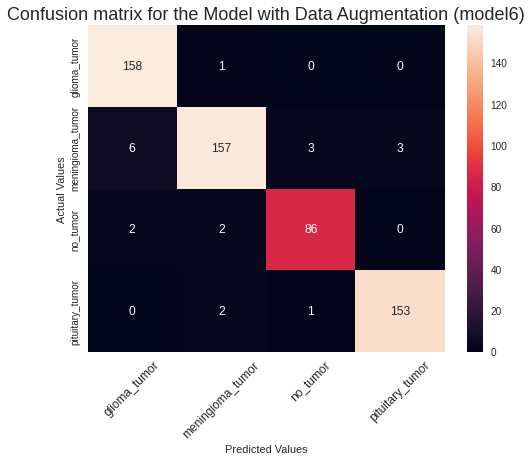

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.99      0.97       159
meningioma_tumor       0.97      0.93      0.95       169
        no_tumor       0.96      0.96      0.96        90
 pituitary_tumor       0.98      0.98      0.98       156

        accuracy                           0.97       574
       macro avg       0.96      0.96      0.96       574
    weighted avg       0.97      0.97      0.97       574

---- FINAL SCORE (CUSTOM FORMULA)  0.9601564729013932


In [ ]:
show_full_classification_report(model6, valid_ds, "Model with Data Augmentation (model6)")

This is clearly our best score so far: an impressive 97% accuracy and 96% precision in detecting the healthy patients was reached.

### Model with BatchNormalization

In [31]:
model7 = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(128, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(32, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes, activation=tf.nn.softmax)
])


model7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model7.build(input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)    

In [32]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20, restore_best_weights=True)
mc = ModelCheckpoint('batch_normalization_model.h5', monitor='val_accuracy', mode='max')

set_seed()

training_dist = get_distribution(train_ds)
total = np.sum(training_dist)
class_weight = {0: total / training_dist[0],  1: total / training_dist[1], 2: total / training_dist[2], 3: total / training_dist[3]}
class_weight

max_epochs=100
history7 = model7.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc],
  class_weight = class_weight
)

Epoch 1/100
72/72 [==============================] - 49s 474ms/step - loss: 3.5414 - accuracy: 0.6437 - val_loss: 3.9607 - val_accuracy: 0.1568
Epoch 2/100
72/72 [==============================] - 31s 424ms/step - loss: 2.5428 - accuracy: 0.7404 - val_loss: 5.1348 - val_accuracy: 0.2997
Epoch 3/100
72/72 [==============================] - 31s 426ms/step - loss: 2.2846 - accuracy: 0.7626 - val_loss: 3.6383 - val_accuracy: 0.2927
Epoch 4/100
72/72 [==============================] - 31s 433ms/step - loss: 1.9996 - accuracy: 0.7975 - val_loss: 2.3962 - val_accuracy: 0.3763
Epoch 5/100
72/72 [==============================] - 31s 435ms/step - loss: 1.5943 - accuracy: 0.8419 - val_loss: 2.6022 - val_accuracy: 0.1672
Epoch 6/100
72/72 [==============================] - 32s 438ms/step - loss: 1.3995 - accuracy: 0.8589 - val_loss: 4.9750 - val_accuracy: 0.1568
Epoch 7/100
72/72 [==============================] - 31s 436ms/step - loss: 1.2688 - accuracy: 0.8637 - val_loss: 1.7485 - val_accuracy:

In [35]:
model7.save_weights('batch_normalization_model_weights_only.h5')

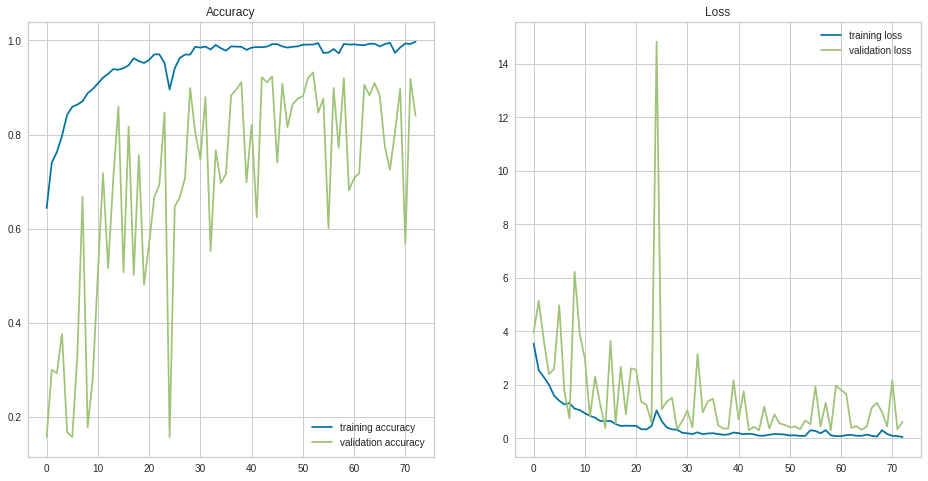

In [34]:
plot_loss_accuracy_history(history7)

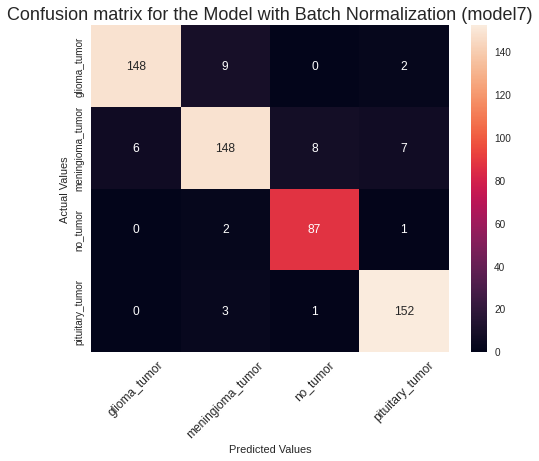

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.93      0.95       159
meningioma_tumor       0.91      0.88      0.89       169
        no_tumor       0.91      0.97      0.94        90
 pituitary_tumor       0.94      0.97      0.96       156

        accuracy                           0.93       574
       macro avg       0.93      0.94      0.93       574
    weighted avg       0.93      0.93      0.93       574

---- FINAL SCORE (CUSTOM FORMULA)  0.9215728620073685


In [33]:
show_full_classification_report(model7, valid_ds, "Model with Batch Normalization (model7)")

### Model with a lower Learning Rate

In [37]:
model8 = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes, activation=tf.nn.softmax)
])


model8.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model8.build(input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

model8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 1)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)     

In [38]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20, restore_best_weights=True)
mc = ModelCheckpoint('low_learning_rate_model.h5', monitor='val_accuracy', mode='max')

set_seed()

training_dist = get_distribution(train_ds)
total = np.sum(training_dist)
class_weight = {0: total / training_dist[0],  1: total / training_dist[1], 2: total / training_dist[2], 3: total / training_dist[3]}
class_weight

max_epochs=300
history8 = model8.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=max_epochs,
  callbacks=[es, mc],
  class_weight = class_weight
)

Epoch 1/300
72/72 [==============================] - 32s 421ms/step - loss: 4.8946 - accuracy: 0.3916 - val_loss: 1.0812 - val_accuracy: 0.5470
Epoch 2/300
72/72 [==============================] - 30s 413ms/step - loss: 4.0846 - accuracy: 0.5483 - val_loss: 0.9658 - val_accuracy: 0.6132
Epoch 3/300
72/72 [==============================] - 30s 418ms/step - loss: 3.3805 - accuracy: 0.6416 - val_loss: 0.8648 - val_accuracy: 0.6115
Epoch 4/300
72/72 [==============================] - 30s 422ms/step - loss: 3.0451 - accuracy: 0.6738 - val_loss: 0.7145 - val_accuracy: 0.7387
Epoch 5/300
72/72 [==============================] - 31s 427ms/step - loss: 2.7826 - accuracy: 0.6986 - val_loss: 0.8115 - val_accuracy: 0.6620
Epoch 6/300
72/72 [==============================] - 31s 425ms/step - loss: 2.6615 - accuracy: 0.7078 - val_loss: 0.6167 - val_accuracy: 0.7526
Epoch 7/300
72/72 [==============================] - 31s 425ms/step - loss: 2.4311 - accuracy: 0.7339 - val_loss: 0.5618 - val_accuracy:

### Conclusions

After several steps of optimizing our CNN, we reached a model with an impressive result on the validation dataset: the final score, according to our custom formula is 0.96.

Let's summarize the optimizations and observations that lead us to this score:

1. making the CNN deeper helps the network capture larger, more generic patterns
2. dropout and data augmentation significantly reduced the overfitting
3. applying class weights allowed us to highlight the importance of not missing any patient with a tumor, compared to the importance of getting the type of the tumor right

## Fine-tunning ResNet50

As we have seen in the transfer learning process, the ResNet50 seems to perform the best, compared to InceptionV3, AlexNet and VGG16. So, let's try to fine-tune this model, but we should also add some data augmentation to it.

### Training head with data augmentation

In [ ]:
pretrained_base_resnet_fine_tune = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling=max
)
pretrained_base_resnet_fine_tune.trainable = False

In [ ]:
model_resnet_fine_tune = Sequential([
    data_augmentation,
    pretrained_base_resnet_fine_tune,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes)
])

In [ ]:
model_resnet_fine_tune.compile(
    optimizer=tf.optimizers.SGD(lr=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model_resnet_fine_tune.build(input_shape=(None, 224, 224, 3))
model_resnet_fine_tune.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, None, None, None)  0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_15 (Dense)            (None, 32)                3211296   
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 4)                 132       
                                                                 
Total params: 26,800,196
Trainable params: 3,212,484
N

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('resnet_model_data_aug.h5', monitor='val_accuracy', mode='max')

history_resnet_data_aug = model_resnet_fine_tune.fit(
    train_ds_resnet,
    validation_data=valid_ds_resnet,
    epochs=50,
    callbacks=[es, mc]
)

Epoch 1/50
72/72 [==============================] - 20s 227ms/step - loss: 0.9485 - accuracy: 0.6315 - val_loss: 0.5914 - val_accuracy: 0.7718
Epoch 2/50
72/72 [==============================] - 16s 214ms/step - loss: 0.4850 - accuracy: 0.8118 - val_loss: 0.5094 - val_accuracy: 0.7927
Epoch 3/50
72/72 [==============================] - 16s 219ms/step - loss: 0.3921 - accuracy: 0.8524 - val_loss: 0.4380 - val_accuracy: 0.8275
Epoch 4/50
72/72 [==============================] - 26s 359ms/step - loss: 0.3251 - accuracy: 0.8767 - val_loss: 0.4116 - val_accuracy: 0.8362
Epoch 5/50
72/72 [==============================] - 23s 314ms/step - loss: 0.2823 - accuracy: 0.8933 - val_loss: 0.3640 - val_accuracy: 0.8537
Epoch 6/50
72/72 [==============================] - 19s 261ms/step - loss: 0.2671 - accuracy: 0.9016 - val_loss: 0.4460 - val_accuracy: 0.8380
Epoch 7/50
72/72 [==============================] - 18s 252ms/step - loss: 0.2396 - accuracy: 0.9107 - val_loss: 0.3864 - val_accuracy: 0.8659

In [ ]:
model_resnet_fine_tune.save_weights('resnet_model_data_aug_weights_only.h5')

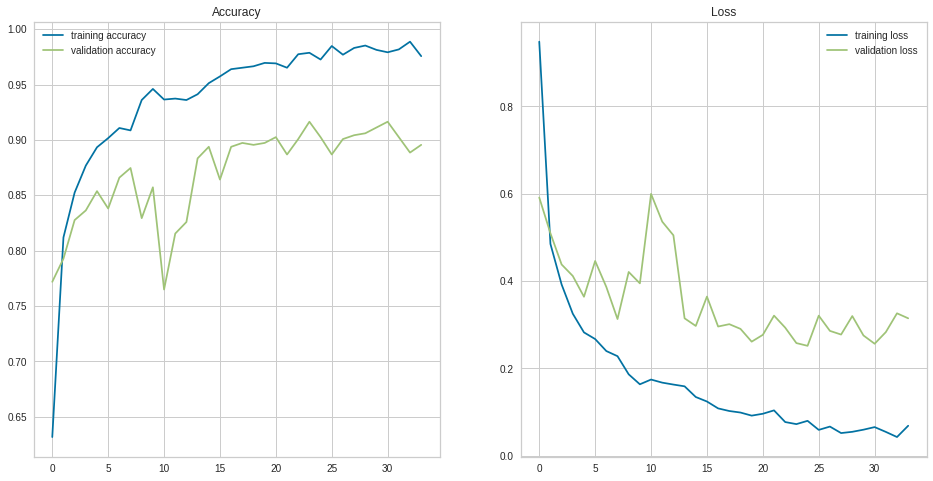

In [ ]:
plot_loss_accuracy_history(history_resnet_data_aug)

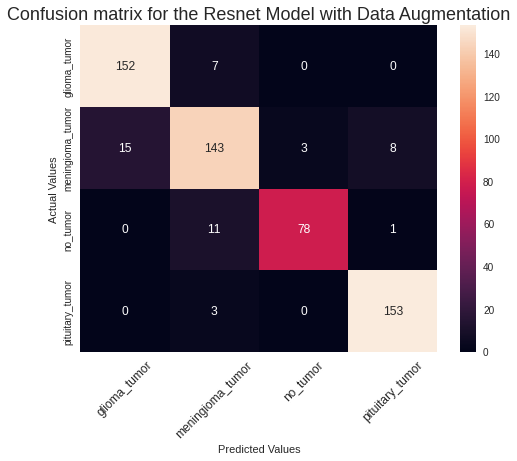

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.96      0.93       159
meningioma_tumor       0.87      0.85      0.86       169
        no_tumor       0.96      0.87      0.91        90
 pituitary_tumor       0.94      0.98      0.96       156

        accuracy                           0.92       574
       macro avg       0.92      0.91      0.92       574
    weighted avg       0.92      0.92      0.92       574

---- FINAL SCORE (CUSTOM FORMULA)  0.9376770547761113


In [ ]:
show_full_classification_report(model_resnet_fine_tune, valid_ds_resnet, "Resnet Model with Data Augmentation")

### Fine-tunning

In [ ]:
pretrained_base_resnet_fine_tune.trainable = True
print("Number of layers in the base model: ", len(pretrained_base_resnet_fine_tune.layers))

Number of layers in the base model:  175


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_base_resnet_fine_tune.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model_resnet_fine_tune.compile(
    optimizer=tf.optimizers.SGD(lr=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model_resnet_fine_tune.build(input_shape=(None, 224, 224, 3))
model_resnet_fine_tune.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, None, None, None)  0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_15 (Dense)            (None, 32)                3211296   
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 4)                 132       
                                                                 
Total params: 26,800,196
Trainable params: 20,427,972


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=40, restore_best_weights=True)
mc = ModelCheckpoint('resnet_model_fine_tune.h5', monitor='val_accuracy', mode='max')

history_resnet_fine_tune = model_resnet_fine_tune.fit(
    train_ds_resnet,
    validation_data=valid_ds_resnet,
    initial_epoch=history_resnet_data_aug.epoch[-1],
    epochs=200,
    callbacks=[es, mc]
)

Epoch 34/200
72/72 [==============================] - 20s 271ms/step - loss: 0.0532 - accuracy: 0.9856 - val_loss: 0.2648 - val_accuracy: 0.9111
Epoch 35/200
72/72 [==============================] - 17s 238ms/step - loss: 0.0497 - accuracy: 0.9887 - val_loss: 0.2625 - val_accuracy: 0.9146
Epoch 36/200
72/72 [==============================] - 17s 238ms/step - loss: 0.0439 - accuracy: 0.9891 - val_loss: 0.2683 - val_accuracy: 0.9094
Epoch 37/200
72/72 [==============================] - 20s 272ms/step - loss: 0.0448 - accuracy: 0.9909 - val_loss: 0.2628 - val_accuracy: 0.9129
Epoch 38/200
72/72 [==============================] - 18s 241ms/step - loss: 0.0436 - accuracy: 0.9895 - val_loss: 0.2700 - val_accuracy: 0.9111
Epoch 39/200
72/72 [==============================] - 18s 240ms/step - loss: 0.0501 - accuracy: 0.9856 - val_loss: 0.2659 - val_accuracy: 0.9094
Epoch 40/200
72/72 [==============================] - 18s 241ms/step - loss: 0.0470 - accuracy: 0.9848 - val_loss: 0.2689 - val_ac

In [ ]:
model_resnet_fine_tune.save_weights('resnet_model_fine_tune3_weights_only.h5')

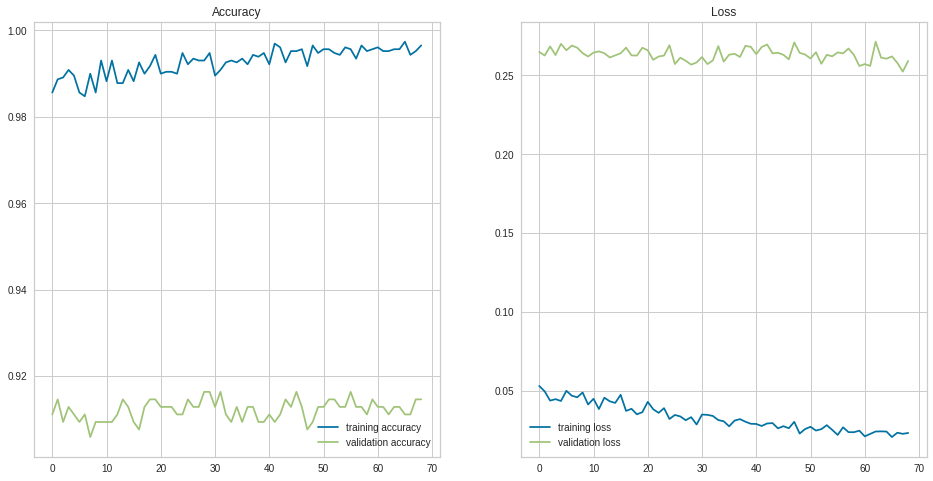

In [ ]:
plot_loss_accuracy_history(history_resnet_fine_tune)

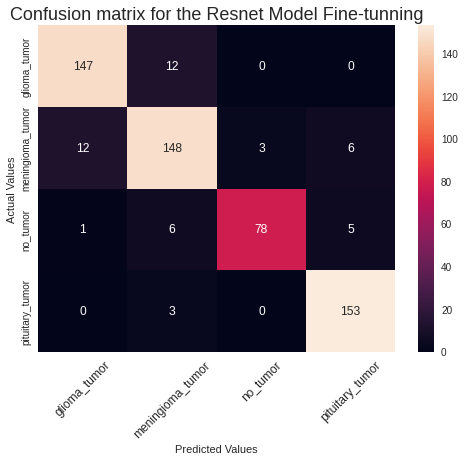

                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.92      0.92       159
meningioma_tumor       0.88      0.88      0.88       169
        no_tumor       0.96      0.87      0.91        90
 pituitary_tumor       0.93      0.98      0.96       156

        accuracy                           0.92       574
       macro avg       0.92      0.91      0.92       574
    weighted avg       0.92      0.92      0.92       574

---- FINAL SCORE (CUSTOM FORMULA)  0.9374444620181195


In [ ]:
show_full_classification_report(model_resnet_fine_tune, valid_ds_resnet, "Resnet Model Fine-tunning")

Trying to unfreeze some more layers..

In [ ]:
pretrained_base_resnet_fine_tune.trainable = True
print("Number of layers in the base model: ", len(pretrained_base_resnet_fine_tune.layers))

Number of layers in the base model:  175


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_base_resnet_fine_tune.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model_resnet_fine_tune.compile(
    optimizer=tf.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model_resnet_fine_tune.build(input_shape=(None, 224, 224, 3))
model_resnet_fine_tune.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, None, None, None)  0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_15 (Dense)            (None, 32)                3211296   
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 4)                 132       
                                                                 
Total params: 26,800,196
Trainable params: 22,665,412


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=40, restore_best_weights=True)
mc = ModelCheckpoint('resnet_model_fine_tune.h5', monitor='val_accuracy', mode='max')

history_resnet_fine_tune = model_resnet_fine_tune.fit(
    train_ds_resnet,
    validation_data=valid_ds_resnet,
    initial_epoch=history_resnet_fine_tune.epoch[-1],
    epochs=200,
    callbacks=[es, mc]
)

Epoch 102/200
72/72 [==============================] - 29s 291ms/step - loss: 0.2959 - accuracy: 0.9003 - val_loss: 0.4594 - val_accuracy: 0.8990
Epoch 103/200
72/72 [==============================] - 20s 278ms/step - loss: 0.0898 - accuracy: 0.9665 - val_loss: 0.3105 - val_accuracy: 0.9129
Epoch 104/200
72/72 [==============================] - 20s 274ms/step - loss: 0.0576 - accuracy: 0.9817 - val_loss: 0.2611 - val_accuracy: 0.9373
Epoch 105/200
72/72 [==============================] - 20s 275ms/step - loss: 0.0824 - accuracy: 0.9747 - val_loss: 0.2698 - val_accuracy: 0.9216
Epoch 106/200
72/72 [==============================] - 21s 284ms/step - loss: 0.0301 - accuracy: 0.9909 - val_loss: 0.2639 - val_accuracy: 0.9408
Epoch 107/200
72/72 [==============================] - 20s 276ms/step - loss: 0.0301 - accuracy: 0.9930 - val_loss: 0.2618 - val_accuracy: 0.9321
Epoch 108/200
72/72 [==============================] - 22s 306ms/step - loss: 0.0443 - accuracy: 0.9869 - val_loss: 0.2649 -

In [ ]:
model_resnet_fine_tune.save_weights('resnet_model_fine_tune_final_weights_only.h5')

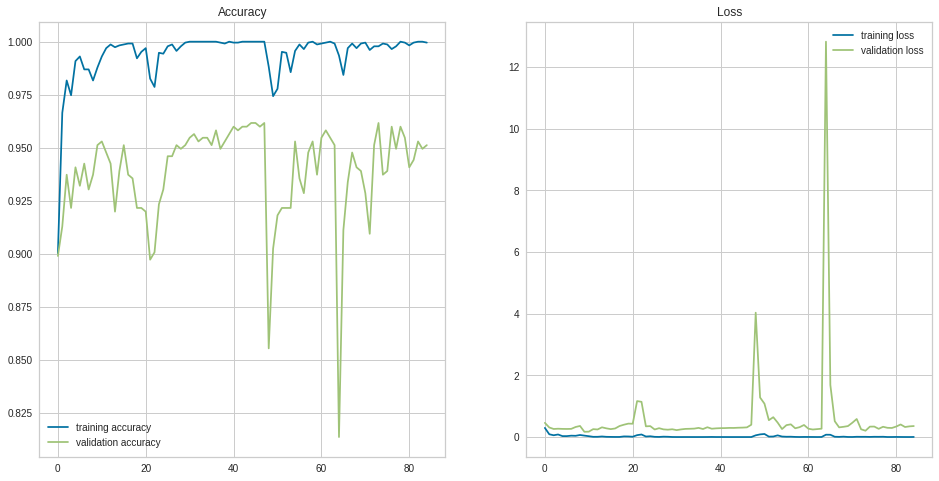

In [ ]:
plot_loss_accuracy_history(history_resnet_fine_tune)

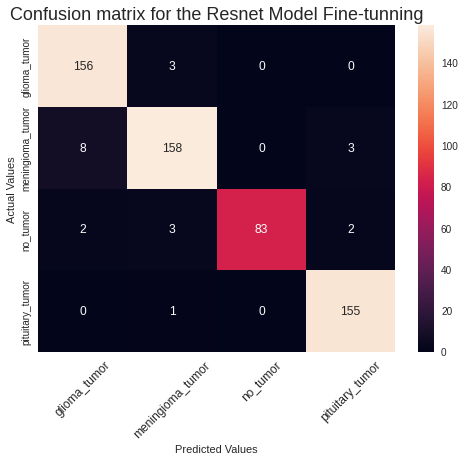

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.98      0.96       159
meningioma_tumor       0.96      0.93      0.95       169
        no_tumor       1.00      0.92      0.96        90
 pituitary_tumor       0.97      0.99      0.98       156

        accuracy                           0.96       574
       macro avg       0.97      0.96      0.96       574
    weighted avg       0.96      0.96      0.96       574

---- FINAL SCORE (CUSTOM FORMULA)  0.9789819104859018


In [ ]:
show_full_classification_report(model_resnet_fine_tune, valid_ds_resnet, "Resnet Model Fine-tunning")

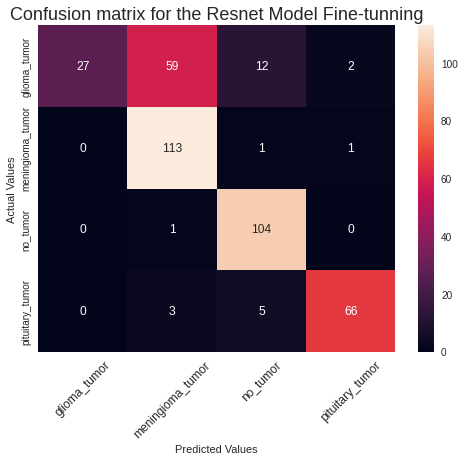

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.27      0.43       100
meningioma_tumor       0.64      0.98      0.78       115
        no_tumor       0.85      0.99      0.92       105
 pituitary_tumor       0.96      0.89      0.92        74

        accuracy                           0.79       394
       macro avg       0.86      0.78      0.76       394
    weighted avg       0.85      0.79      0.75       394

---- FINAL SCORE (CUSTOM FORMULA)  0.8181016054492534


In [ ]:
show_full_classification_report(model_resnet_fine_tune, test_ds_resnet, "Resnet Model Fine-tunning")

### Try Reloading the Model's weights (todo: delete this section)

In [ ]:
reloaded_model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes, activation=tf.nn.softmax)
])

reloaded_model.build(input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

# Restore the weights
reloaded_model.load_weights('data_augmentation_model_weights_only.h5')

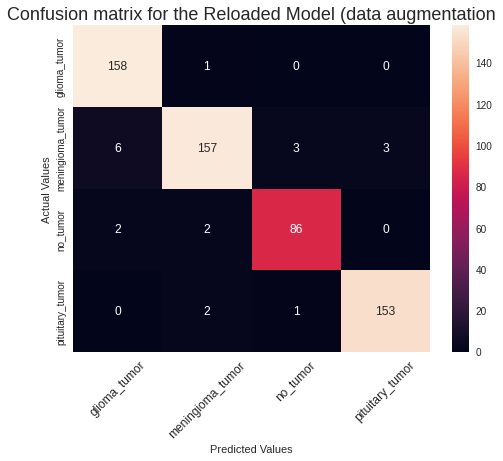

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.99      0.97       159
meningioma_tumor       0.97      0.93      0.95       169
        no_tumor       0.96      0.96      0.96        90
 pituitary_tumor       0.98      0.98      0.98       156

        accuracy                           0.97       574
       macro avg       0.96      0.96      0.96       574
    weighted avg       0.97      0.97      0.97       574

---- FINAL SCORE (CUSTOM FORMULA)  0.9601564729013932


In [ ]:
show_full_classification_report(reloaded_model, valid_ds, "Reloaded Model (data augmentation")

### Try Reloading Full Model (todo: delete this section)

In [ ]:
reloaded_full_model = tf.keras.models.load_model('data_augmentation_model.h5')

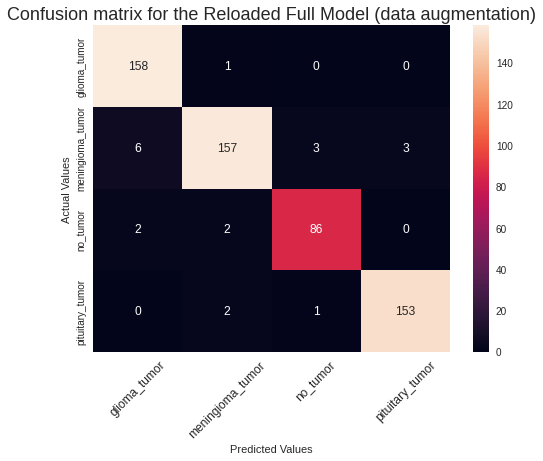

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.99      0.97       159
meningioma_tumor       0.97      0.93      0.95       169
        no_tumor       0.96      0.96      0.96        90
 pituitary_tumor       0.98      0.98      0.98       156

        accuracy                           0.97       574
       macro avg       0.96      0.96      0.96       574
    weighted avg       0.97      0.97      0.97       574

---- FINAL SCORE (CUSTOM FORMULA)  0.9601564729013932


In [ ]:
show_full_classification_report(reloaded_full_model, valid_ds, "Reloaded Full Model (data augmentation)")